# Proyecto 03 - Series de Tiempo | Gastón Nievas

# Presentación del proyecto

# Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

## Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**



# PARTE A - Exploración de Datos

# Preparación del Dataset

Tiempo aproximado de ejecución de la carga de datos y ejecución del notebook completo: 12 minutos. 

In [ ]:
#!pip install pmdarima
#!pip install skforecast

In [ ]:
# Importamos las librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Importamos librerias de Statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf
from statsmodels.graphics.tsaplots import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Modelo
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from xgboost import XGBRegressor

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as RMSE

# Librería SKFORECAST para Random Forest
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals


In [ ]:
# Función de formato para títulos
def bold(texto): 
  print('\033[1m\033[4m' + texto + '\033[0m\033[0m')

In [ ]:
# CARGA DE DATASETS
# Para datasets online descomentar True. Para datos offline descomentar False.

#data_online = False
data_online = True

if data_online:
  data_2017 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2017.csv', sep =',')
  data_2018 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2018.csv', sep =',')
  data_2019 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/flujo-vehicular-por-unidades-de-peaje-ausa/flujo-vehicular-2019.csv', sep =',')
  data_2020 = pd.read_csv('http://cdn.buenosaires.gob.ar/datosabiertos/datasets/ausa/flujo-vehicular-por-unidades-peaje-ausa/flujo-vehicular-2020.csv', sep =',')
else:
  data_2017 = pd.read_csv('./datasets/flujo-vehicular-2017.csv')
  data_2018 = pd.read_csv('./datasets/flujo-vehicular-2018.csv')
  data_2019 = pd.read_csv('./datasets/flujo-vehicular-2019.csv')
  data_2020 = pd.read_csv('./datasets/flujo-vehicular-2020.csv')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#url2017 = '/content/drive/MyDrive/Colab Notebooks/Acámica - DS - G62/Sprint 3/Proyecto 3 - Acamica - DS 62/flujo-vehicular-2017.csv'
#url2018 = '/content/drive/MyDrive/Colab Notebooks/Acámica - DS - G62/Sprint 3/Proyecto 3 - Acamica - DS 62/flujo-vehicular-2018.csv' 
#url2019 = '/content/drive/MyDrive/Colab Notebooks/Acámica - DS - G62/Sprint 3/Proyecto 3 - Acamica - DS 62/flujo-vehicular-2019.csv'
#data_2017 = pd.read_csv(url2017, sep =',')
#data_2018 = pd.read_csv(url2018, sep =',')
#data_2019 = pd.read_csv(url2019, sep =',')
# Me quedé sin espacio en Drive para el dataset 2020 y busque otra forma

## Exploración inicial

In [ ]:
print(data_2020.head())
print(data_2020.tail())

   periodo                fecha  ...    sentido cantidad_pasos
0   2020.0  2020-01-01 00:00:00  ...     Centro           24.0
1   2020.0  2020-01-01 00:00:00  ...  Provincia           80.0
2   2020.0  2020-01-01 00:00:00  ...  Provincia            1.0
3   2020.0  2020-01-01 00:00:00  ...     Centro            1.0
4   2020.0  2020-01-01 00:00:00  ...  Provincia            1.0

[5 rows x 13 columns]
         periodo       fecha  ...    sentido cantidad_pasos
2533738   2020.0  2020-12-31  ...     Centro            1.0
2533739   2020.0  2020-12-31  ...  Provincia            1.0
2533740   2020.0  2020-12-31  ...     Centro            1.0
2533741   2020.0  2020-12-31  ...     Centro            2.0
2533742   2020.0  2020-12-31  ...  Provincia            1.0

[5 rows x 13 columns]


In [ ]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  ...  tipo_vehiculo  forma_pago cantidad_pasos
0     2019  2019-01-01            0  ...        Liviano  NO COBRADO             22
1     2019  2019-01-01            0  ...        Liviano    TELEPASE              6
2     2019  2019-01-01            0  ...        Liviano  NO COBRADO             53
3     2019  2019-01-01            0  ...        Liviano    TELEPASE             18
4     2019  2019-01-01            0  ...        Liviano    EFECTIVO             16

[5 rows x 10 columns]

In [ ]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  ...  tipo_vehiculo  forma_pago cantidad_pasos
0     2018  2018-01-01            0  ...        Liviano  NO COBRADO             29
1     2018  2018-01-01            0  ...        Liviano    TELEPASE              9
2     2018  2018-01-01            1  ...        Liviano  NO COBRADO             73
3     2018  2018-01-01            1  ...        Liviano    TELEPASE             39
4     2018  2018-01-01            2  ...        Liviano  NO COBRADO            115

[5 rows x 10 columns]

In [ ]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  ...  tipo_vehiculo  forma_pago cantidad_pasos
0     2017  2017-01-01            0  ...        Liviano  NO COBRADO             25
1     2017  2017-01-01            0  ...        Liviano    TELEPASE              7
2     2017  2017-01-01            1  ...        Liviano  NO COBRADO              5
3     2017  2017-01-01            1  ...        Liviano    EFECTIVO              2
4     2017  2017-01-01            1  ...        Liviano    EFECTIVO             94

[5 rows x 10 columns]

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**


In [ ]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


Observamos que los nombres y las cantidades de estaciones varía de 2017 a 2019.

In [ ]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


Los sentidos son hacia Centro y hacia Provincia.

In [ ]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


Los tipos de vehículo se clasifican en Liviano y Pesado. 

In [ ]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


Observamos que las formas de pago cambiaron de 2017 a 2019. 

In [ ]:
# Noción de la cantidad de pasos por año en las autopistas de CABA
bold('Cantidad de pasos por año en las autopistas de CABA:')
print('Cantidad de pasos en 2017: ', data_2017.cantidad_pasos.sum())
print('Cantidad de pasos hacia Centro en 2017: ', data_2017.cantidad_pasos[data_2017.sentido == 'Centro'].sum())
print('Cantidad de pasos hacia Provincia en 2017: ', data_2017.cantidad_pasos[data_2017.sentido == 'Provincia'].sum())
print('------------')
print('Cantidad de pasos en 2018: ', data_2018.cantidad_pasos.sum())
print('Cantidad de pasos hacia Centro en 2018: ', data_2018.cantidad_pasos[data_2018.sentido == 'Centro'].sum())
print('Cantidad de pasos hacia Provincia en 2018: ', data_2018.cantidad_pasos[data_2018.sentido == 'Provincia'].sum())
print('------------')
print('Cantidad de pasos en 2019: ', data_2019.cantidad_pasos.sum())
print('Cantidad de pasos hacia Centro en 2019: ', data_2019.cantidad_pasos[data_2019.sentido == 'Centro'].sum())
print('Cantidad de pasos hacia Provincia en 2019: ', data_2019.cantidad_pasos[data_2019.sentido == 'Provincia'].sum())

Cantidad de pasos por año en las autopistas de CABA:
Cantidad de pasos en 2017:  124833490
Cantidad de pasos hacia Centro en 2017:  61225844
Cantidad de pasos hacia Provincia en 2017:  63607646
------------
Cantidad de pasos en 2018:  123093692
Cantidad de pasos hacia Centro en 2018:  60094633
Cantidad de pasos hacia Provincia en 2018:  62999059
------------
Cantidad de pasos en 2019:  126710525
Cantidad de pasos hacia Centro en 2019:  61781193
Cantidad de pasos hacia Provincia en 2019:  64929332


Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

In [ ]:
#DATASET COMPLETO: Unimos los 3 datasets de los años 2017, 2018 y 2019
dataset_completo = pd.concat([data_2019, data_2018, data_2017])

In [ ]:
dataset_completo.head()

periodo       fecha  hora_inicio  ...  tipo_vehiculo  forma_pago cantidad_pasos
0     2019  2019-01-01            0  ...        Liviano  NO COBRADO             22
1     2019  2019-01-01            0  ...        Liviano    TELEPASE              6
2     2019  2019-01-01            0  ...        Liviano  NO COBRADO             53
3     2019  2019-01-01            0  ...        Liviano    TELEPASE             18
4     2019  2019-01-01            0  ...        Liviano    EFECTIVO             16

[5 rows x 10 columns]

In [ ]:
bold('Cantidad de registros por forma de pago:')
print(dataset_completo.forma_pago.value_counts())

Cantidad de registros por forma de pago:
TELEPASE                1027861
EFECTIVO                1020176
EXENTO                   464708
INFRACCION               405034
NO COBRADO               380450
TARJETA DISCAPACIDAD     186454
T. DISCAPACIDAD           76001
MONEDERO                     14
Otros                         8
Name: forma_pago, dtype: int64


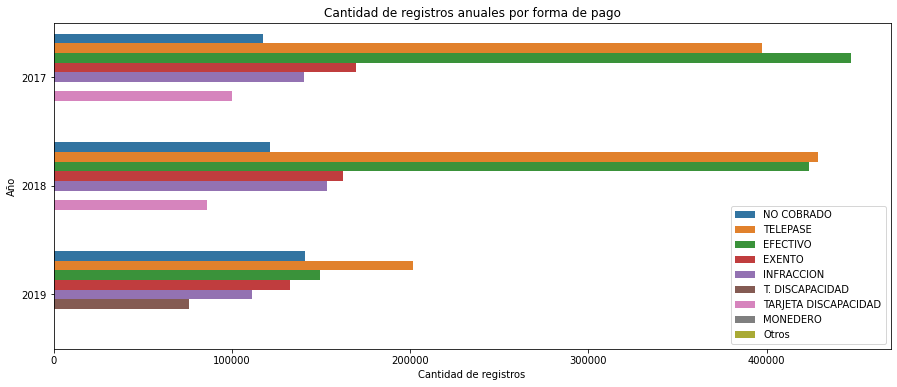

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(y=dataset_completo.periodo, hue=dataset_completo.forma_pago)
plt.title('Cantidad de registros anuales por forma de pago')
plt.ylabel('Año')
plt.xlabel('Cantidad de registros')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Agrupado por forma de pago
forma_pago = dataset_completo.groupby([dataset_completo.forma_pago, dataset_completo.periodo], as_index=False).sum()
forma_pago

forma_pago  periodo  hora_inicio  hora_fin  cantidad_pasos
0               EFECTIVO     2017      5313337   5350068        69502938
1               EFECTIVO     2018      5018078   5059991        60225521
2               EFECTIVO     2019      1737568   1745908        53621459
3                 EXENTO     2017      2031898   2055699         1677497
4                 EXENTO     2018      1936409   1960752         1250539
5                 EXENTO     2019      1569531   1579055         1310757
6             INFRACCION     2017      1766495   1805346          629550
7             INFRACCION     2018      1914931   1960790          720320
8             INFRACCION     2019      1351672   1364172         1098472
9               MONEDERO     2017          192       206              16
10            NO COBRADO     2017      1464825   1493275         4845670
11            NO COBRADO     2018      1504267   1530979         6072877
12            NO COBRADO     2019      1702770   1718938         6267683
13                 Otros     2017          107       115              22
14       T. DISCAPACIDAD     2019       933469    944646          841695
15  TARJETA DISCAPACIDAD     2017      1227076   1243710         1565099
16  TARJETA DISCAPACIDAD     2018      1064276   1080280         1061614
17              TELEPASE     2017      4627688   4661268        46612698
18              TELEPASE     2018      5045970   5080559        53762821
19              TELEPASE     2019      2351013   2358697        63570459

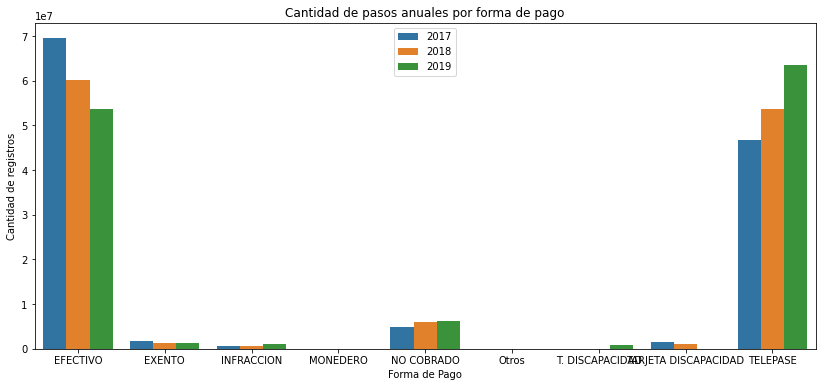

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(x=forma_pago.forma_pago, y=forma_pago.cantidad_pasos, hue=forma_pago.periodo)
plt.title('Cantidad de pasos anuales por forma de pago')
plt.xlabel('Forma de Pago')
plt.ylabel('Cantidad de registros')
plt.legend(loc='best')
plt.show()

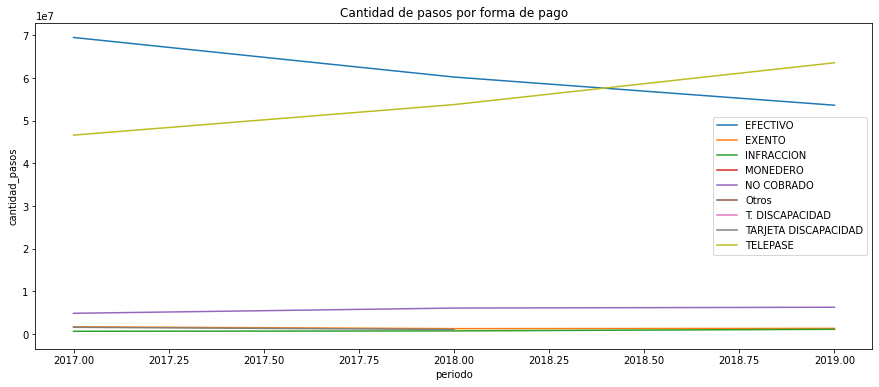

In [ ]:
# Gráfico de las Formas de Pago
plt.figure(figsize=(15, 6))
sns.lineplot(x=forma_pago.periodo, y= forma_pago.cantidad_pasos, hue=forma_pago.forma_pago)
plt.title('Cantidad de pasos por forma de pago')
plt.legend(loc='best')
plt.show()

Se observa una **disminución en la forma de pago "EFECTIVO"** y un **aumento en la forma de pago "TELEPASE"**. 

In [ ]:
data_2017.forma_pago.value_counts()

EFECTIVO                447203
TELEPASE                397420
EXENTO                  169889
INFRACCION              140275
NO COBRADO              117730
TARJETA DISCAPACIDAD    100106
MONEDERO                    14
Otros                        8
Name: forma_pago, dtype: int64

In [ ]:
data_2018.forma_pago.value_counts()

TELEPASE                429053
EFECTIVO                423633
EXENTO                  162103
INFRACCION              153331
NO COBRADO              121440
TARJETA DISCAPACIDAD     86348
Name: forma_pago, dtype: int64

In [ ]:
data_2019.forma_pago.value_counts()

TELEPASE           201388
EFECTIVO           149340
NO COBRADO         141280
EXENTO             132716
INFRACCION         111428
T. DISCAPACIDAD     76001
Name: forma_pago, dtype: int64

En 2017 se observa que la cantidad de registros en EFECTIVO es mayor a TELEPASE. En 2018 la cantidad de registros se equilibra, y en 2019 la cantidad de registros de TELEPASE es mayor a EFECTIVO. 


---
# Dataset Illia-Efectivo


Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [ ]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset_completo.estacion=='Illia', dataset_completo.forma_pago == 'EFECTIVO')
dataset = dataset_completo[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [ ]:
dataset.tail()

fecha  hora_fin      dia    sentido tipo_vehiculo  cantidad_pasos
1372316  2017-12-31        22  Domingo  Provincia        Pesado               8
1372319  2017-12-31        23  Domingo  Provincia       Liviano               8
1372320  2017-12-31        23  Domingo  Provincia       Liviano             148
1372324  2017-12-31        23  Domingo  Provincia        Pesado               1
1372326  2017-12-31        23  Domingo  Provincia        Pesado               1

In [ ]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [ ]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [ ]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

## Análisis Exploratorio de Datos


In [ ]:
# Noción de la cantidad de vehículos que circulan por las autopistas de CABA
bold('Cantidad de pasos para el dataset 2017, 2018 y 2019 de la estación Illia con pago en Efectivo')
print('Cantidad total de pasos: ', dataset.cantidad_pasos.sum())
print('Cantidad total de pasos hacia Centro: ', dataset.cantidad_pasos[dataset.sentido == 'Centro'].sum())
print('Cantidad total de pasos hacia Provincia: ', dataset.cantidad_pasos[dataset.sentido == 'Provincia'].sum())

Cantidad de pasos para el dataset 2017, 2018 y 2019 de la estación Illia con pago en Efectivo
Cantidad total de pasos:  47865581
Cantidad total de pasos hacia Centro:  24707366
Cantidad total de pasos hacia Provincia:  23158215


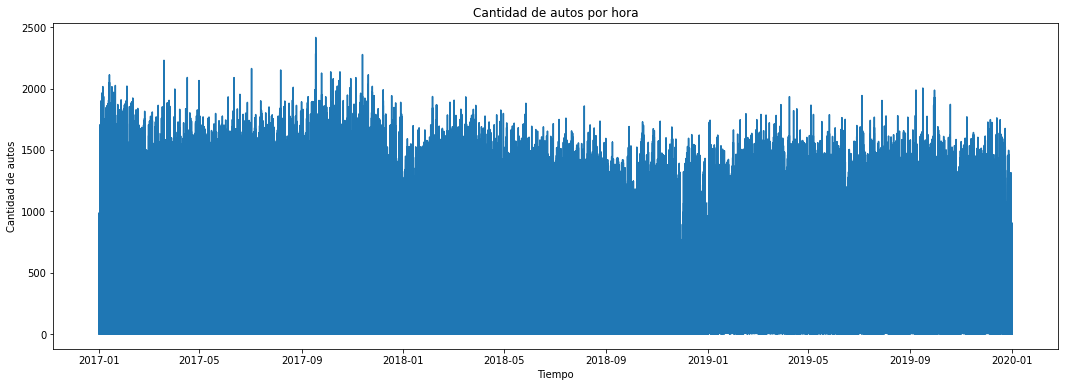

In [ ]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (18,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.title('Cantidad de autos por hora')
plt.show()

In [ ]:
dataset.head(10)

dia    sentido tipo_vehiculo  cantidad_pasos      fecha
0  Domingo  Provincia        Pesado               1 2017-01-01
1  Domingo  Provincia       Liviano               9 2017-01-01
2  Domingo  Provincia       Liviano             644 2017-01-01
3  Domingo  Provincia        Pesado               6 2017-01-01
4  Domingo  Provincia        Pesado               1 2017-01-01
5  Domingo  Provincia        Pesado               2 2017-01-01
6  Domingo     Centro       Liviano              23 2017-01-01
7  Domingo     Centro        Pesado               1 2017-01-01
8  Domingo     Centro        Pesado              21 2017-01-01
9  Domingo     Centro        Pesado              10 2017-01-01

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238869 entries, 0 to 238868
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   sentido         238869 non-null  object        
 2   tipo_vehiculo   238869 non-null  object        
 3   cantidad_pasos  238869 non-null  int64         
 4   fecha           238869 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.1+ MB


In [ ]:
dataset.describe()

cantidad_pasos
count   238869.000000
mean       200.384232
std        403.246904
min          1.000000
25%          2.000000
50%         11.000000
75%        104.000000
max       2416.000000

In [ ]:
# Suma total de pasos
dataset.cantidad_pasos.sum()

47865581

In [ ]:
dataset.dia.value_counts()

Viernes      35196
Miércoles    35005
Jueves       34914
Martes       34335
Lunes        34144
Sábado       33351
Domingo      31924
Name: dia, dtype: int64

In [ ]:
# Dataset cantidad de datos por dia de semana. 
por_dia = dataset.groupby(['dia']).sum()
# Ordenamos los valores del dataset por cantidad de pasos
por_dia = por_dia.sort_values(by='cantidad_pasos', ascending=True)
por_dia

cantidad_pasos
dia                      
Domingo           5791961
Sábado            6441715
Lunes             6691387
Martes            6865551
Miércoles         7125526
Jueves            7302169
Viernes           7647272

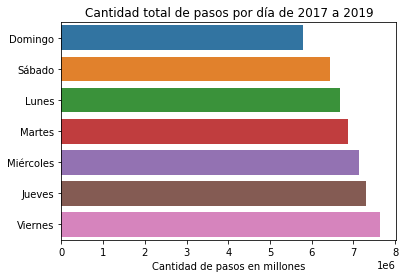

In [ ]:
sns.barplot(x = por_dia.cantidad_pasos, y = por_dia.index.values)
plt.title('Cantidad total de pasos por día de 2017 a 2019')
plt.xlabel('Cantidad de pasos en millones')
plt.show()

Se observa un incremento en la cantidad de pasos desde el lunes hacia el viernes, siendo el viernes el día con mayor cantidad de pasos, y los findes de semana la menor cantidad de pasos. Esto nos puede dar la idea de una estacional semanal de 7 días. 

In [ ]:
# Dataset cantidad de datos por tipo de vehículo. 
por_tipo = dataset.groupby(['tipo_vehiculo']).sum()
# Ordenamos los valores del dataset por cantidad de pasos
por_tipo = por_tipo.sort_values(by='cantidad_pasos', ascending=True)
por_tipo

cantidad_pasos
tipo_vehiculo                
Pesado                1527052
Liviano              46338529

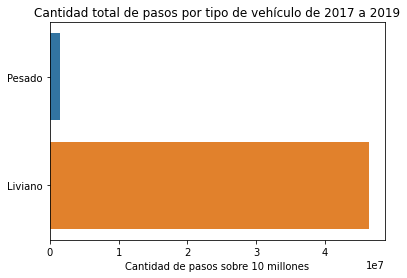

In [ ]:
sns.barplot(x = por_tipo.cantidad_pasos, y = por_tipo.index.values)
plt.title('Cantidad total de pasos por tipo de vehículo de 2017 a 2019')
plt.xlabel('Cantidad de pasos sobre 10 millones')
plt.show()

Se observa que la cantidad de pasos de vehículos Pesados por el peaje Illia es considerablemente menor a los vehículos Livianos. 



In [ ]:
# Dataset cantidad de datos por tipo de vehículo. 
por_sentido = dataset.groupby(['sentido']).sum()
# Ordenamos los valores del dataset por cantidad de pasos
por_sentido = por_sentido.sort_values(by='cantidad_pasos', ascending=True)
por_sentido

cantidad_pasos
sentido                  
Provincia        23158215
Centro           24707366

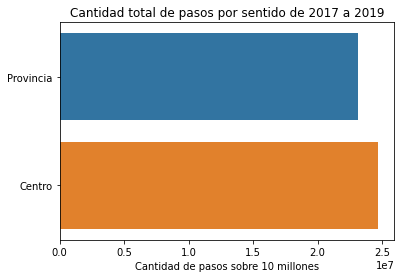

In [ ]:
#fig = plt.figure(figsize=(10,5))
sns.barplot(x = por_sentido.cantidad_pasos, y = por_sentido.index.values)
plt.title('Cantidad total de pasos por sentido de 2017 a 2019')
plt.xlabel('Cantidad de pasos sobre 10 millones')
plt.show()

Se observa más cantidad de pasos hacia Centro que hacia Provincia por el peaje Illia.

In [ ]:
# Dataset cantidad de datos por dia de semana y por sentido de circulación.
por_dia_sentido = dataset.groupby(['dia', 'sentido']).sum()
por_dia_sentido

cantidad_pasos
dia       sentido                  
Domingo   Centro            2978394
          Provincia         2813567
Jueves    Centro            3756857
          Provincia         3545312
Lunes     Centro            3459619
          Provincia         3231768
Martes    Centro            3546712
          Provincia         3318839
Miércoles Centro            3694598
          Provincia         3430928
Sábado    Centro            3295920
          Provincia         3145795
Viernes   Centro            3975266
          Provincia         3672006

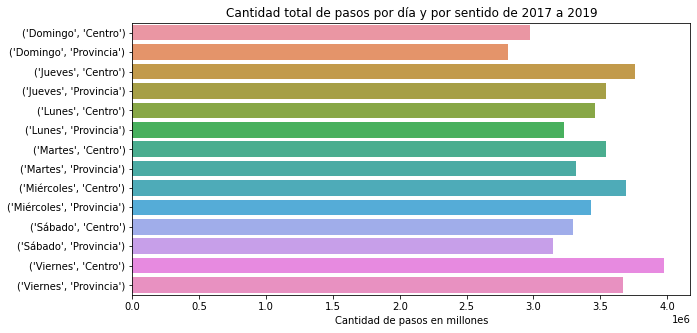

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x = por_dia_sentido.cantidad_pasos, y = por_dia_sentido.index.values)
plt.title('Cantidad total de pasos por día y por sentido de 2017 a 2019')
plt.xlabel('Cantidad de pasos en millones')
plt.show()

Se observa que todos los días hay más cantidad de pasos hacia Centro que hacia Provincia por el peaje Illia. 

In [ ]:
# Ordenamos los valores del dataset por cantidad de pasos
por_dia_sentido = por_dia_sentido.sort_values(by='cantidad_pasos', ascending=False)
por_dia_sentido

cantidad_pasos
dia       sentido                  
Viernes   Centro            3975266
Jueves    Centro            3756857
Miércoles Centro            3694598
Viernes   Provincia         3672006
Martes    Centro            3546712
Jueves    Provincia         3545312
Lunes     Centro            3459619
Miércoles Provincia         3430928
Martes    Provincia         3318839
Sábado    Centro            3295920
Lunes     Provincia         3231768
Sábado    Provincia         3145795
Domingo   Centro            2978394
          Provincia         2813567

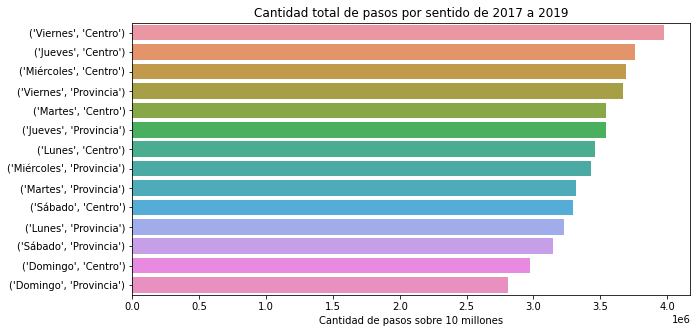

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x = por_dia_sentido.cantidad_pasos, y = por_dia_sentido.index.values)
plt.title('Cantidad total de pasos por sentido de 2017 a 2019')
plt.xlabel('Cantidad de pasos sobre 10 millones')
plt.show()

In [ ]:
# Dataset cantidad de datos por dia de semana y por tipo de vehículo.
por_dia_tipo = dataset.groupby(['dia', 'tipo_vehiculo']).sum()
# Ordenamos los valores del dataset por cantidad de pasos
por_dia_tipo = por_dia_tipo.sort_values(by='cantidad_pasos', ascending=False)
por_dia_tipo

cantidad_pasos
dia       tipo_vehiculo                
Viernes   Liviano               7381933
Jueves    Liviano               7046410
Miércoles Liviano               6870255
Martes    Liviano               6626080
Lunes     Liviano               6470104
Sábado    Liviano               6270310
Domingo   Liviano               5673437
Viernes   Pesado                 265339
Jueves    Pesado                 255759
Miércoles Pesado                 255271
Martes    Pesado                 239471
Lunes     Pesado                 221283
Sábado    Pesado                 171405
Domingo   Pesado                 118524

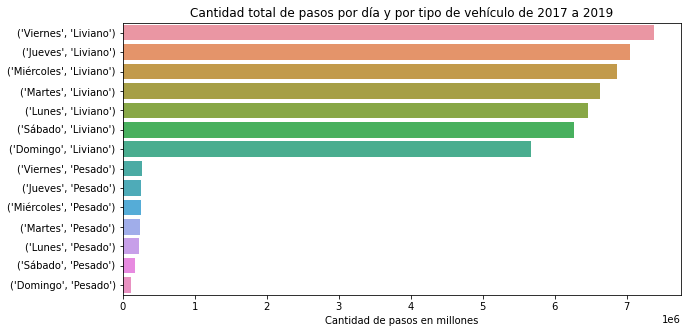

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x = por_dia_tipo.cantidad_pasos, y = por_dia_tipo.index.values)
plt.title('Cantidad total de pasos por día y por tipo de vehículo de 2017 a 2019')
plt.xlabel('Cantidad de pasos en millones')
plt.show()

Se observa que la cantidad de pasos para ambos tipos de vehículo aumenta durante los días de semana de lunes a viernes, siendo el viernes el día de más tránsito para ambos tipos de vehiculo. Luego disminuye el fin de semana, siendo el domingo el día con menos tránsito para ambos tipos de vehículo. 

In [ ]:
hora = dataset.groupby(dataset.fecha.dt.hour).sum().sort_values('cantidad_pasos', ascending=False)
bold('Horarios con mayor circulación:')
hora.head(5)

Horarios con mayor circulación:


cantidad_pasos
fecha                
18            3115036
19            3071455
14            3005578
17            2993721
16            2969568

In [ ]:
bold('Horarios con menor circulación:')
hora.tail(5)

Horarios con menor circulación:


cantidad_pasos
fecha                
6              781617
2              614594
3              429898
5              411330
4              334860

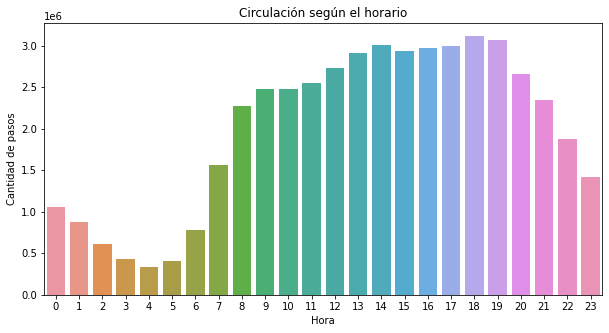

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(y=hora.cantidad_pasos, x=hora.index.values)
plt.xlabel('Hora')
plt.ylabel('Cantidad de pasos')
plt.title('Circulación según el horario')
plt.show()

La mayor cantidad de tráfico se da entre las 8hs y las 21hs, siendo la hora pico entre las 18 y las 19 horas. 

##Serie de tiempo DIARIA

In [ ]:
#Resampleamos nuestros datos para agrupar POR DÍA, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

In [ ]:
#10 Días de mayor flujo vehicular: 
bold('10 Días de mayor flujo vehicular:')
diario.sort_values('cantidad_pasos', ascending=False).head(10)

10 Días de mayor flujo vehicular:


cantidad_pasos
fecha                     
2017-12-07           63127
2017-11-24           61594
2017-10-13           61421
2017-11-10           61382
2017-11-17           61259
2017-10-06           61099
2017-12-01           60985
2017-12-15           60280
2017-01-13           59651
2017-09-29           59604

Observamos que los 10 días con mayor flujo vehicular corresponden al año 2017, lo que puede ser una señal de tendencia de menor flujo en los años siguientes. 

In [ ]:
#10 Días de menor flujo vehicular: 
bold('10 Días de menor flujo vehicular:')
diario.sort_values('cantidad_pasos', ascending=True).head(10)

10 Días de menor flujo vehicular:


cantidad_pasos
fecha                     
2018-06-25               0
2018-09-25               0
2018-11-30               0
2019-05-29               0
2017-04-06              40
2018-12-01             350
2019-01-13           18076
2018-11-29           19728
2019-12-01           20553
2019-12-31           21447

Se observan valores nulos y atípicos en los primeros 6 resultados. Luego los días con menor flujo vehicular corresponden a fin de 2018 y 2019. 

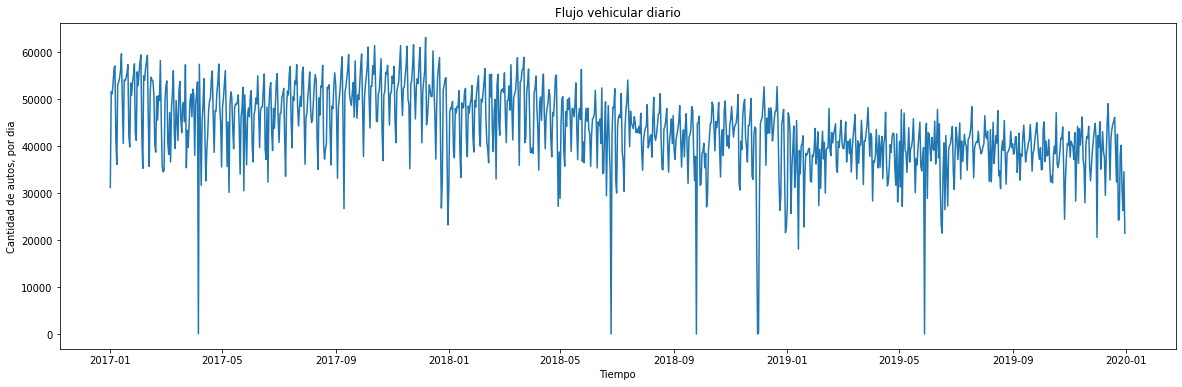

In [ ]:
plt.figure(figsize = (20,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Flujo vehicular diario')
plt.show()

### Outliers diario

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Boxplot cantidad de pasos diarios')

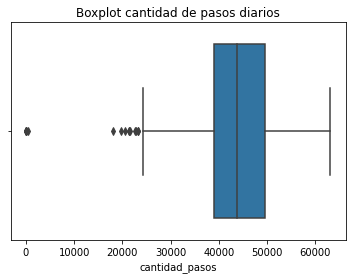

In [ ]:
# OUTLIERS
sns.boxplot(diario.cantidad_pasos)
plt.title('Boxplot cantidad de pasos diarios')

In [ ]:
# Reemplazamos los outliers por nan
diario.cantidad_pasos[diario.cantidad_pasos < diario.cantidad_pasos.std()*3] = np.nan
# Interpolamos
diario = diario.interpolate()

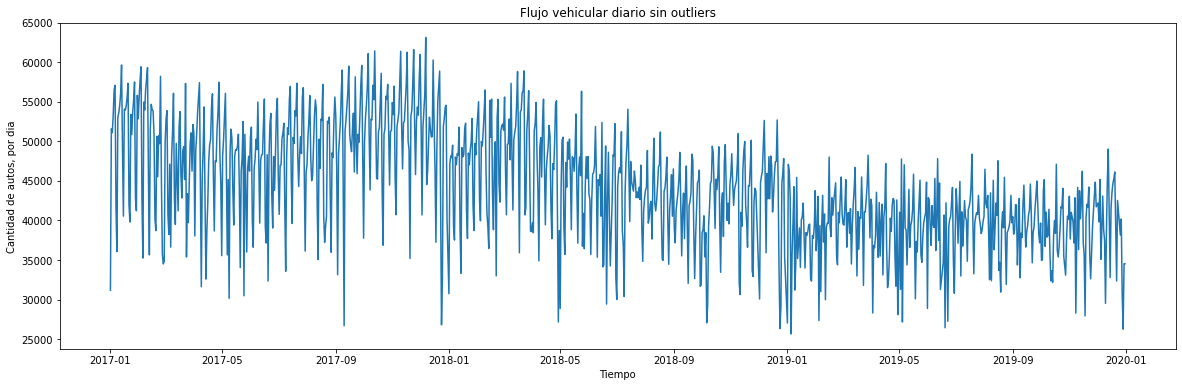

In [ ]:
plt.figure(figsize = (20,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Flujo vehicular diario sin outliers')
plt.show()

In [ ]:
diario.shape

(1095, 1)

In [ ]:
ventana=60
diario_promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana, center = False).mean()
diario_promedio_tendencia[1084:]

fecha
2019-12-21    39857.791667
2019-12-22    39701.125000
2019-12-23    39716.758333
2019-12-24    39666.969444
2019-12-25    39736.091667
2019-12-26    39800.925000
2019-12-27    39919.275000
2019-12-28    39803.458333
2019-12-29    39565.658333
2019-12-30    39471.725000
2019-12-31    39329.558333
Freq: D, Name: cantidad_pasos, dtype: float64

In [ ]:
diario_promedio_tendencia.isna().sum()

59

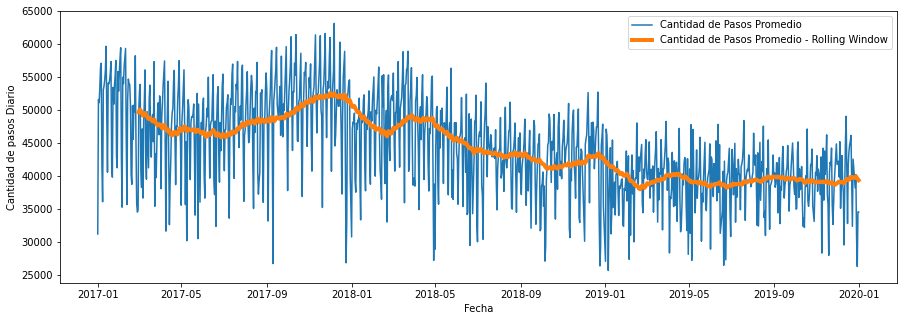

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de Pasos Promedio')
plt.plot(diario_promedio_tendencia, lw = 4, label = 'Cantidad de Pasos Promedio - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos Diario')
plt.legend()
plt.show()

##Serie de tiempo SEMANAL

In [ ]:
# Resampleamos nuestros datos para agrupar POR SEMANA, y asi tal vez lograr una visualización mas amigable
semanal = diario.resample(rule='w', closed='left').mean()
# semanal = dataset.resample(rule='W', on = 'fecha', closed='left', label ='right').sum()
print(semanal.shape)
print(semanal.head())
print(semanal.tail())

(157, 1)
            cantidad_pasos
fecha                     
2017-01-08    48904.285714
2017-01-15    51704.571429
2017-01-22    51136.714286
2017-01-29    50452.428571
2017-02-05    52196.428571
            cantidad_pasos
fecha                     
2019-12-08    40860.071429
2019-12-15    39860.714286
2019-12-22    41902.571429
2019-12-29    37799.714286
2020-01-05    31768.333333


In [ ]:
#Eliminamos la última semana para obtener años de 52 semanas
semanal = semanal[:-1]

In [ ]:
semanal.describe()

cantidad_pasos
count      156.000000
mean     44138.190476
std       4792.357299
min      34904.000000
25%      39857.535714
50%      43609.214286
75%      47912.750000
max      53867.714286

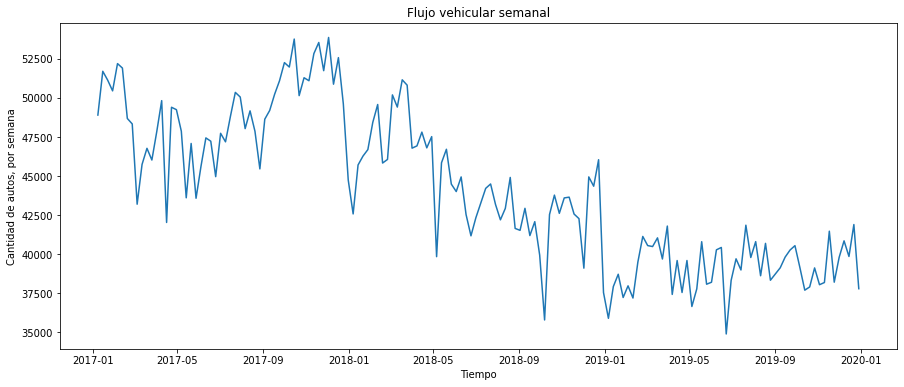

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.title('Flujo vehicular semanal')
plt.show()

### Outliers semanal
Para el resampleo semanal vamos a utilizar la media del resalmpleo diario, por lo que no vamos a tener valores atípicos ni nulos. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Boxplot cantidad de pasos semanal')

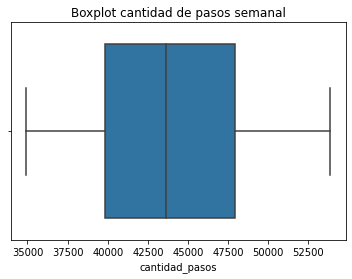

In [ ]:
# OUTLIERS
sns.boxplot(semanal.cantidad_pasos)
plt.title('Boxplot cantidad de pasos semanal')

In [ ]:
semanal.shape

(156, 1)

In [ ]:
ventana=13
semanal_promedio_tendencia = semanal.cantidad_pasos.rolling(window=ventana, center = False).mean()
semanal_promedio_tendencia[144:]

fecha
2019-10-13    39655.736264
2019-10-20    39352.043956
2019-10-27    39300.725275
2019-11-03    39088.780220
2019-11-10    39055.505495
2019-11-17    39115.472527
2019-11-24    39105.868132
2019-12-01    39187.384615
2019-12-08    39319.840659
2019-12-15    39322.961538
2019-12-22    39448.335165
2019-12-29    39236.598901
Freq: W-SUN, Name: cantidad_pasos, dtype: float64

In [ ]:
semanal_promedio_tendencia.isna().sum()

12

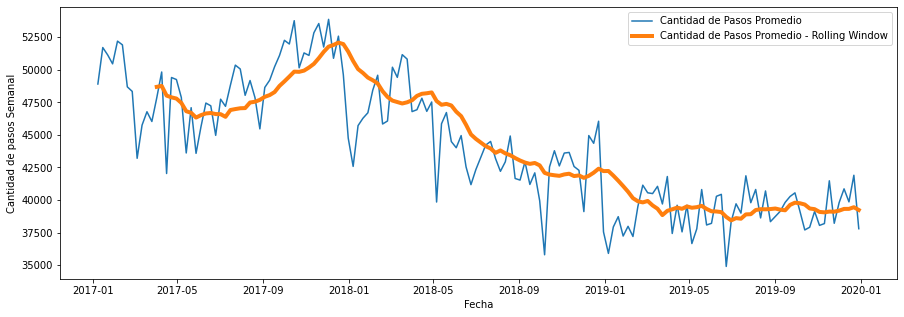

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(semanal.index, semanal.cantidad_pasos, label = 'Cantidad de Pasos Promedio')
plt.plot(semanal_promedio_tendencia, lw = 4, label = 'Cantidad de Pasos Promedio - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos Semanal')
plt.legend()
plt.show()

##Serie de tiempo MENSUAL

In [ ]:
#Resampleamos nuestros datos para agrupar POR MES, y asi tal vez lograr una visualización mas amigable
mensual = dataset.resample('M', on = 'fecha').sum()
print(mensual.shape)
mensual.head()

(36, 1)


cantidad_pasos
fecha                     
2017-01-31         1565260
2017-02-28         1363113
2017-03-31         1451214
2017-04-30         1373985
2017-05-31         1407136

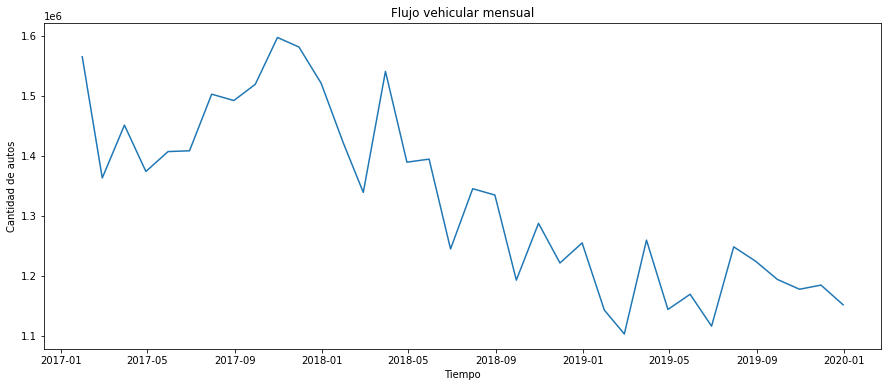

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos')
plt.title('Flujo vehicular mensual')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


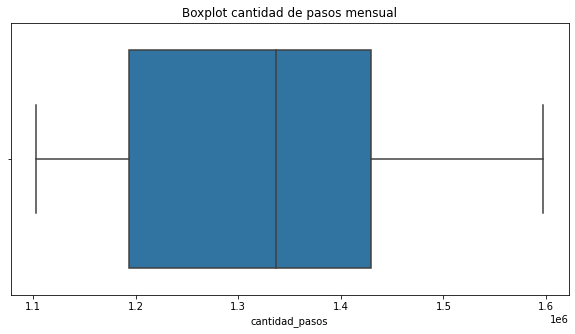

In [ ]:
# OUTLIERS
plt.figure(figsize=(10,5))
sns.boxplot(mensual.cantidad_pasos)
plt.title('Boxplot cantidad de pasos mensual')
plt.show()

In [ ]:
mensual.shape

(36, 1)

In [ ]:
ventana=3
mensual_promedio_tendencia = mensual.cantidad_pasos.rolling(window=ventana, center = False).mean()
mensual_promedio_tendencia[30:]

fecha
2019-07-31    1.177907e+06
2019-08-31    1.196145e+06
2019-09-30    1.222105e+06
2019-10-31    1.198546e+06
2019-11-30    1.185403e+06
2019-12-31    1.171284e+06
Freq: M, Name: cantidad_pasos, dtype: float64

In [ ]:
# Primeros valores
mensual_promedio_tendencia.isna().sum()

2

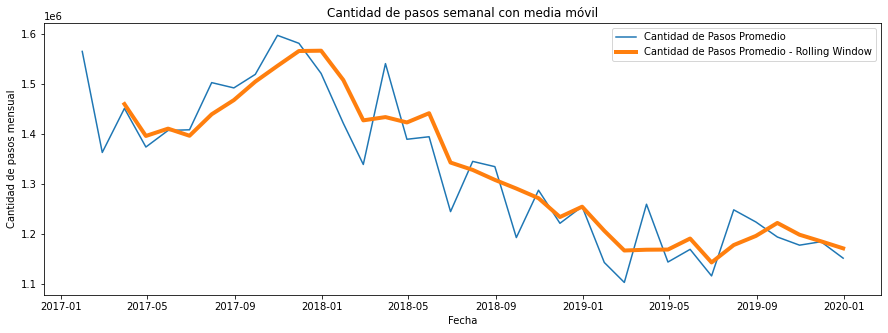

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(mensual.index, mensual.cantidad_pasos, label = 'Cantidad de Pasos Promedio')
plt.plot(mensual_promedio_tendencia, lw = 4, label = 'Cantidad de Pasos Promedio - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos mensual')
plt.title('Cantidad de pasos semanal con media móvil')
plt.legend()
plt.show()

# Análisis gráfico


Comenzaremos haciendo un análisis gráfico diario por año, y luego todos los años juntos. Utilizamos ventana móvil para graficar la media, y haremos una regresión lineal para graficar la tendencia, tanto para el dataset diario, como semanal. 

**DIARIO**

In [ ]:
# Nuevo dataset diario para análisis gráfico
diario2 = diario.copy()
diario2['fecha_numeros']= diario2.index.map(datetime.datetime.toordinal)
diario2.head(3)

cantidad_pasos  fecha_numeros
fecha                                    
2017-01-01         31183.0         736330
2017-01-02         51568.0         736331
2017-01-03         51093.0         736332

In [ ]:
# Datasets diarios por año
diario2017 = diario2[diario2.index.year == 2017].copy()
diario2017['media_movil'] = diario2017.cantidad_pasos.rolling(14).mean()
diario2018 = diario2[diario2.index.year == 2018].copy()
diario2018['media_movil'] = diario2018.cantidad_pasos.rolling(14).mean()
diario2019 = diario2[diario2.index.year == 2019].copy()
diario2019['media_movil'] = diario2019.cantidad_pasos.rolling(14).mean()

In [ ]:
print('Año 2017:\n', diario2017.head(3), diario2017.tail(3))
print('--------')
print('Año 2018:\n', diario2018.head(3), diario2018.tail(3))
print('--------')
print('Año 2019:\n', diario2019.head(3), diario2019.tail(3))

Año 2017:
             cantidad_pasos  fecha_numeros  media_movil
fecha                                                 
2017-01-01         31183.0         736330          NaN
2017-01-02         51568.0         736331          NaN
2017-01-03         51093.0         736332          NaN             cantidad_pasos  fecha_numeros   media_movil
fecha                                                  
2017-12-29         54556.0         736692  48073.571429
2017-12-30         39969.0         736693  47186.214286
2017-12-31         35352.0         736694  46386.928571
--------
Año 2018:
             cantidad_pasos  fecha_numeros  media_movil
fecha                                                 
2018-01-01         30735.0         736695          NaN
2018-01-02         47130.0         736696          NaN
2018-01-03         48162.0         736697          NaN             cantidad_pasos  fecha_numeros   media_movil
fecha                                                  
2018-12-29    35446.000000 

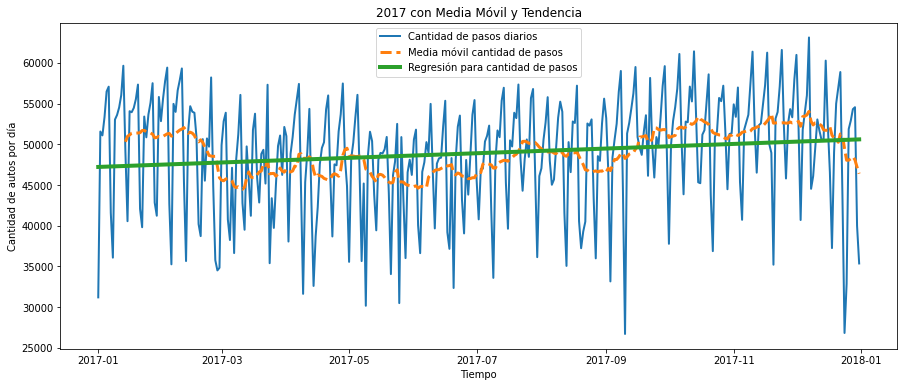

In [ ]:
# 2017 con Media Móvil y Tendencia.
lr = LinearRegression()
lr.fit(diario2017.fecha_numeros.values.reshape(-1, 1), diario2017.cantidad_pasos)
# Gráfico
plt.figure(figsize = (15,6))
plt.plot(diario2017.index, diario2017.cantidad_pasos, lw = 2, label = 'Cantidad de pasos diarios')
plt.plot(diario2017.media_movil, ls = '--', lw = 3, label = 'Media móvil cantidad de pasos')
plt.plot(diario2017.index, lr.predict(diario2017.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Regresión para cantidad de pasos')
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de autos por día")
plt.title('2017 con Media Móvil y Tendencia')
plt.legend()
plt.show()

En el gráfico de 2017 se observa que la media móvil se ubica entre los 45mil y 55mil pasos por día, y la tendencia es levemente en alza. 

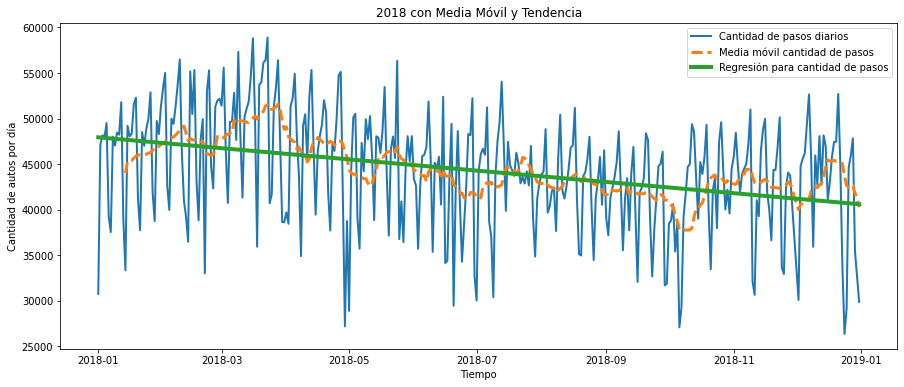

In [ ]:
# 2018 con Media Móvil y Tendencia.
lr = LinearRegression()
lr.fit(diario2018.fecha_numeros.values.reshape(-1, 1), diario2018.cantidad_pasos)

plt.figure(figsize = (15,6))
plt.plot(diario2018.index, diario2018.cantidad_pasos, lw = 2, label = 'Cantidad de pasos diarios')
plt.plot(diario2018.media_movil, ls = '--', lw = 3, label = 'Media móvil cantidad de pasos')
plt.plot(diario2018.index, lr.predict(diario2018.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Regresión para cantidad de pasos')

plt.xlabel("Tiempo")
plt.ylabel("Cantidad de autos por día")
plt.title('2018 con Media Móvil y Tendencia')
plt.legend()
plt.show()

En el gráfico de 2018 se observa que la media móvil disminuye con respecto a 2017, y sus valores se ubica entre los 40mil y 50mil pasos por día. La tendencia es descendente. 

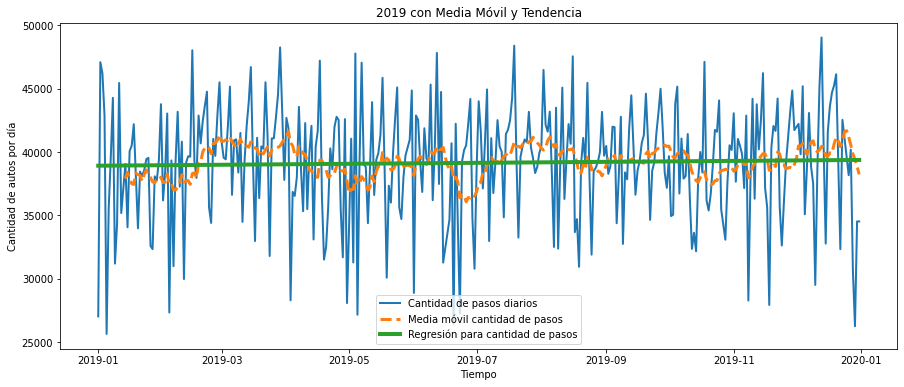

In [ ]:
# 2019 con Media Móvil y Tendencia.
lr = LinearRegression()
lr.fit(diario2019.fecha_numeros.values.reshape(-1, 1), diario2019.cantidad_pasos)

plt.figure(figsize = (15,6))
plt.plot(diario2019.index, diario2019.cantidad_pasos, lw = 2, label = 'Cantidad de pasos diarios')
plt.plot(diario2019.media_movil, ls = '--', lw = 3, label = 'Media móvil cantidad de pasos')
plt.plot(diario2019.index, lr.predict(diario2019.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Regresión para cantidad de pasos')

plt.xlabel("Tiempo")
plt.ylabel("Cantidad de autos por día")
plt.title('2019 con Media Móvil y Tendencia')
plt.legend()
plt.show()

En el gráfico de 2019 se observa que los valores de la media móvil disminuyen con respecto a 2017 y 2018, y se ubican mayormente entre los 38mil y 42mil pasos por día. La tendencia se observa estacionaria en la media. 

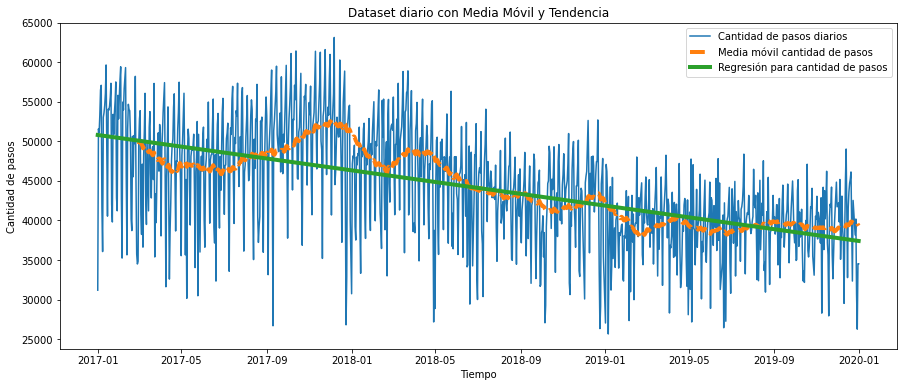

In [ ]:
# Dataset diario con media móvil y tendencia
lr = LinearRegression()
lr.fit(diario2.fecha_numeros.values.reshape(-1, 1), diario2.cantidad_pasos)
# Gráfico
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos,label = 'Cantidad de pasos diarios')
plt.plot(diario_promedio_tendencia, ls = '--', lw = 4, label = 'Media móvil cantidad de pasos')
plt.plot(diario2.index, lr.predict(diario2.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Regresión para cantidad de pasos')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.title('Dataset diario con Media Móvil y Tendencia')
plt.legend()
plt.show()

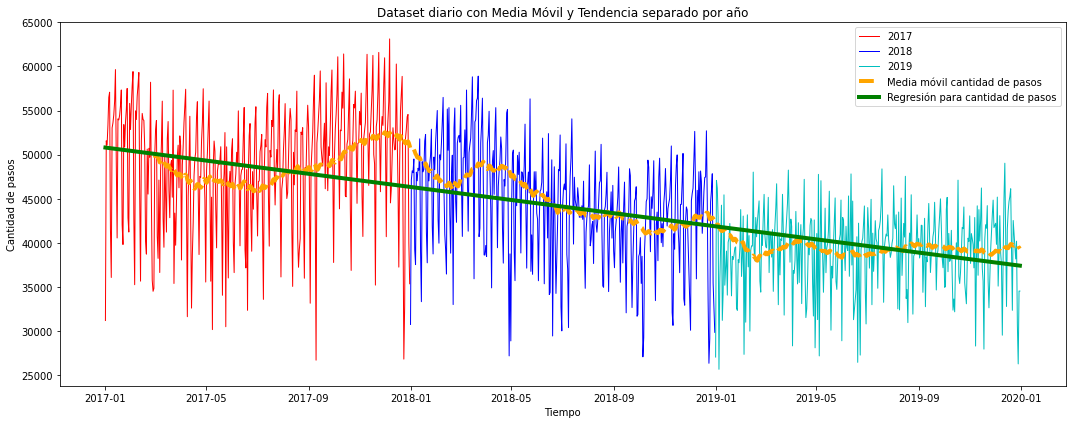

In [ ]:
# Dataset diario con media móvil y tendencia
lr = LinearRegression()
lr.fit(diario2.fecha_numeros.values.reshape(-1, 1), diario2.cantidad_pasos)
# Gráfico
plt.figure(figsize=(15,6))
plt.plot(diario2017.index, diario2017.cantidad_pasos, linestyle='-', linewidth=1, label='2017', color='red')
plt.plot(diario2018.index, diario2018.cantidad_pasos, linestyle='-', linewidth=1, label='2018', color='blue')
plt.plot(diario2019.index, diario2019.cantidad_pasos, linestyle="-",linewidth=1,label="2019",color='c')
plt.plot(diario_promedio_tendencia, ls = '--', lw = 4, color='orange', label = 'Media móvil cantidad de pasos')
plt.plot(diario2.index, lr.predict(diario2.fecha_numeros.values.reshape(-1, 1)), lw = 4, color='green', label = 'Regresión para cantidad de pasos')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.title('Dataset diario con Media Móvil y Tendencia separado por año')
plt.legend()
plt.tight_layout()
plt.show()

La tendencia general para los años de 2017 a 2019 se observa descendiente. También se observa que los valores de la media móvil disminuyen con el pasar del tiempo, para el peaje Illia con forma de pago en Efectivo.  

**SEMANAL**

In [ ]:
# Nuevo dataset semanal para análisis gráfico
semanal2 = semanal.copy()
semanal2['fecha_numeros']= semanal2.index.map(datetime.datetime.toordinal)
semanal2.head(20)

cantidad_pasos  fecha_numeros
fecha                                    
2017-01-08    48904.285714         736337
2017-01-15    51704.571429         736344
2017-01-22    51136.714286         736351
2017-01-29    50452.428571         736358
2017-02-05    52196.428571         736365
2017-02-12    51910.142857         736372
2017-02-19    48687.142857         736379
2017-02-26    48337.285714         736386
2017-03-05    43203.428571         736393
2017-03-12    45747.571429         736400
2017-03-19    46777.857143         736407
2017-03-26    46029.142857         736414
2017-04-02    47853.285714         736421
2017-04-09    49827.000000         736428
2017-04-16    42036.428571         736435
2017-04-23    49404.142857         736442
2017-04-30    49249.857143         736449
2017-05-07    47871.000000         736456
2017-05-14    43613.142857         736463
2017-05-21    47088.571429         736470

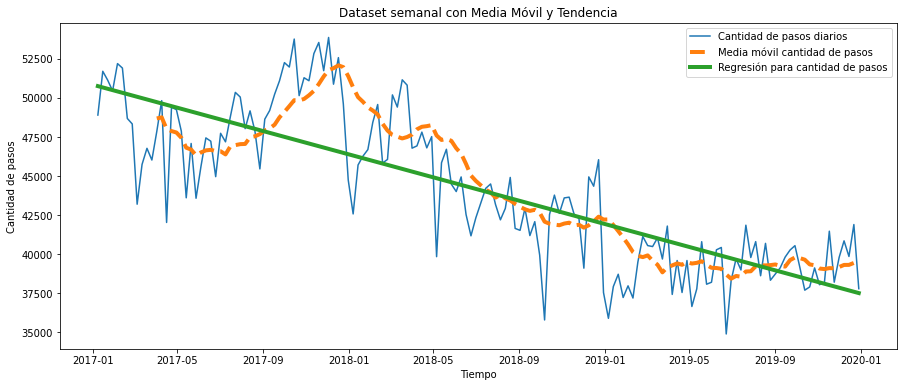

In [ ]:
# Dataset Semanal con media móvil y tendencia
lr = LinearRegression()
lr.fit(semanal2.fecha_numeros.values.reshape(-1, 1), semanal2.cantidad_pasos)
# Gráfico
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos,label = 'Cantidad de pasos diarios')
plt.plot(semanal_promedio_tendencia, ls = '--', lw = 4, label = 'Media móvil cantidad de pasos')
plt.plot(semanal2.index, lr.predict(semanal2.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Regresión para cantidad de pasos')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.title('Dataset semanal con Media Móvil y Tendencia')
plt.legend()
plt.show()

## Componentes de la serie diaria

Realizare una abstracción de los componentes de la serie para preparar los datos, la selección del modelo y los ajustes del modelo. 

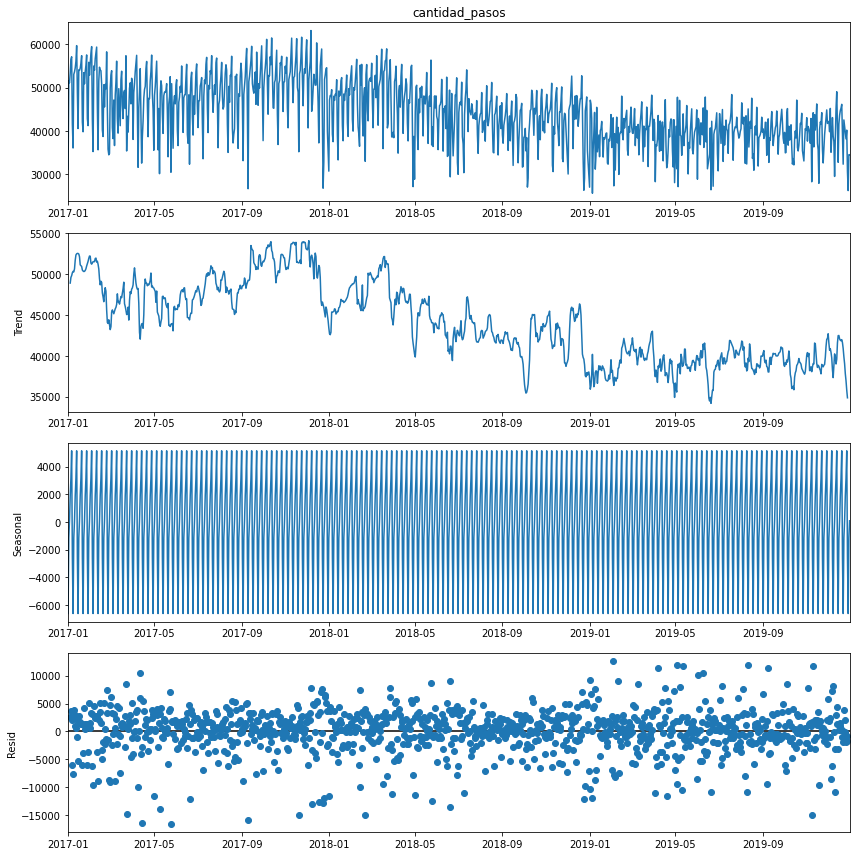

In [ ]:
# DIARIA: Estacionalidad, tendencia, ruido
result = seasonal_decompose(diario.cantidad_pasos, model='additive')
plt.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

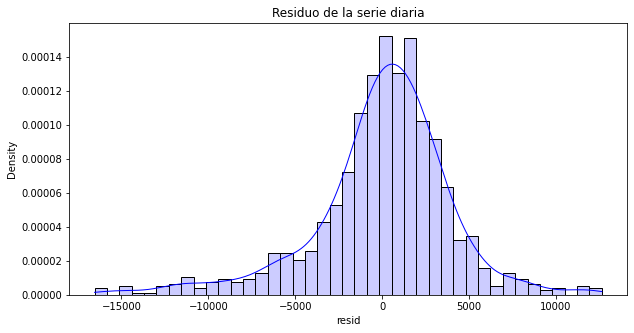

In [ ]:
# Análisis de Residuo de la serie diaria
plt.figure(figsize=(10,5))
plt.title('Residuo de la serie diaria')
sns.histplot(data = result.resid, stat = "density",kde = True, line_kws= {"linewidth":1},color = "blue",alpha= 0.2)

**Análisis de los componentes de la serie DIARIA**

*   *Tendencia*: En terminos generales es descendiente, aunque no se puede ver una linea definida en el gráfico.  
*   *Estacionalidad*: En el gráfico se observa que tiene la misma frecuencia (ancho de los ciclos) y amplitud (altura de los ciclos). Esto sugiere que la estacionalidad es lineal, lo que corresponde con el Modelo Aditivo. 
*   *Residuos*: El ruido se concentra alrededor de cero. La mayor cantidad de valores se encuentra en +/- 5000


## Componentes de la serie semanal

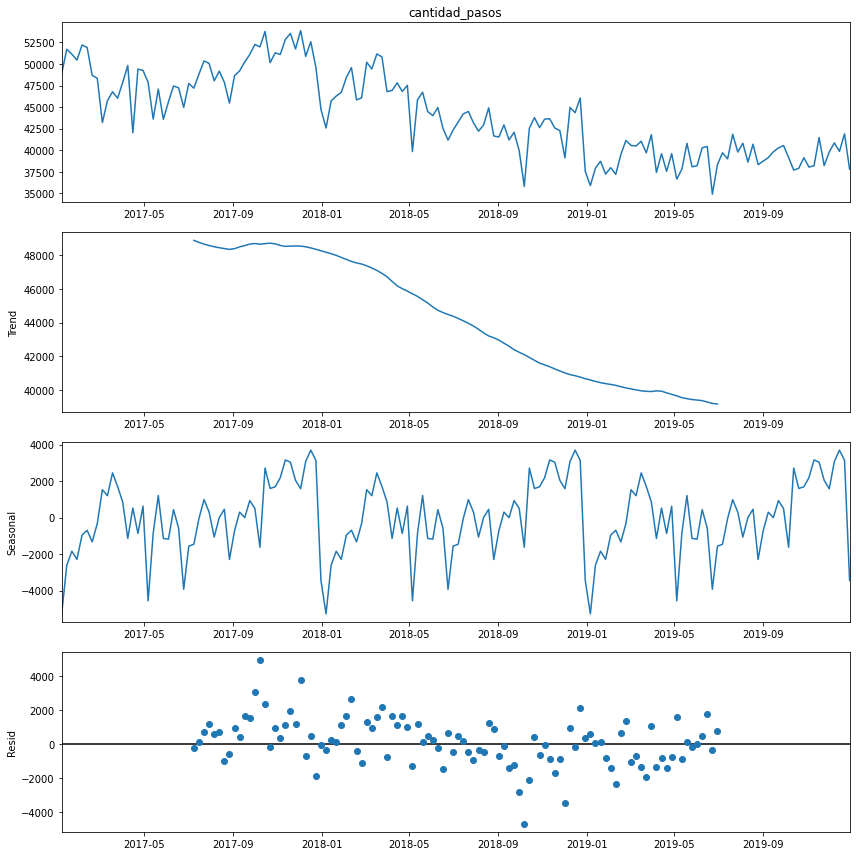

In [ ]:
# SEMANAL: Estacionalidad, tendencia, ruido
result_w = seasonal_decompose(semanal.cantidad_pasos, model='additive')
plt.rcParams['figure.figsize'] = [12,12]
result_w.plot()
plt.show()

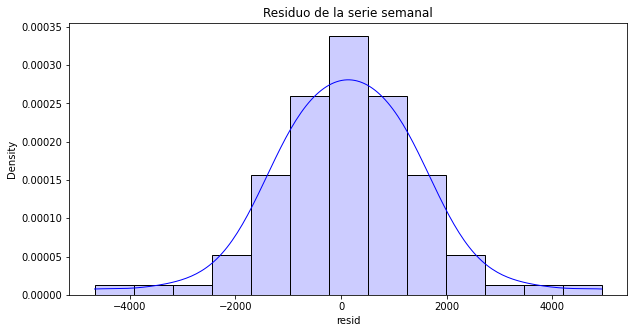

In [ ]:
# Análisis de Residuo de la serie semanal. 
plt.figure(figsize=(10,5))
plt.title('Residuo de la serie semanal')
sns.histplot(data = result_w.resid, stat = "density",kde = True, line_kws= {"linewidth":1},color = "blue",alpha= 0.2)

**Análisis de los componentes de la serie SEMANAL**

*   *Tendencia*: En la serie semanal se observa un gráfico de tendencia claramente descendiente.  
*   *Estacionalidad*: El componente estacional practicamente no varía de año a año. 
*   *Residuos*: El ruido se concentra alrededor de cero. La mayor cantidad de valores se encuentra en +/- 2000. El gráfico se asemeja más a una distribución normal. 

## Conclusiones de análisis exploratorio.

Luego del análisis exploratorio podemos obtener algunas conclusiones sobre el dataset. 

En primer lugar el análisis nos permitio preparar los datos para comenzar a transformar los datos en información. 

*   Outliers: El dataset quedo sin valores faltantes. Con respecto a los valores atípicos fueron tratados eliminando los que podían afectar más los modelos de pronóstico. Quedan algunos valores que difieren más que la media, pero que no fueron tratados como atípicos. Estos valores fueron estudiados, y se debieron a situaciónes particulares, como los que encontramos a mediados y fines de 2018 y 2019 en la serie semanal. En base a investigación podemos atribuir las bajas a aumentos bruzcos en el precio del peaje y del combustible, lo que llevo a las personas a utilizar medios de transporte alternativos, o compartir vehículo, lo que lleva a una disminución temporal en la cantidad de pasos. 

*   Tendencia: Observamos que desde 2017 a 2019 la tendencia global es descreciente, lo que se puede deber a cambios en los medios de traslado de las personas, como también al aumento de la utilización de otros medios de pago en reemplazo del efectivo, como pudimos ver que sucede en el medio de pago TELEPEAJE. 

En conclusión, luego del análisis y el tratamiento de los datos, los gráficos, y los componentes de las series, vamos a trabajar para hacer las predicciones **ARIMA y SARIMA** con la **serie diaria y semanal**; y para **XGBoost y Random Forest** la **serie de tiempo de granularidad semanal** que muestra una tendencia más marcada, una estacionalidad más visible y un ruido más normal. 

# PARTE B - Modelo de Machine Learning

# Pedicciones | Forecasting

**Evaluación del error del modelo**

Debito a las caracteristicas del dataset, y el tratamiento que se aplicó sobre los mismos, trabajaremos con las siguientes métricas para evaluar el desempeño de los modelos: 

**MAPE** = Error porcentual absoluto medio sobre el periodo de validación
* Arregla el problema con la compensación de errores (tal y como lo hacía el MAE) y funciona mejor si no hay extremos en los datos (y no hay ceros).

**RMSE** = Raíz del error cuadratico medio sobre el periodo de validación. 
* Arregla el problema de la cancelación de errores positivos y negativos. 
* Tiene la ventaja de tener las mismas unidades que la variable predicha, por lo que es más fácil de interpretar directamente.

El RMSE estima la desviación estándar de los errores de pronósticos un paso adelante. El MAPE estima el porcentaje promedio del error de pronostico un paso adelante. Los
valores pequeños de RMSE y MAPE son deseables. 



In [ ]:
# En base al análisis realizado previamente, vamos a trabajar con la serie de tiempo Semanal. 
print(semanal.info())
print(bold('Filas y columnas:'), semanal.shape)
print(bold('Primeras 3 líneas:'), semanal.head(3))
print(bold('Últimas 3 líneas:'), semanal.tail(3))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 2017-01-08 to 2019-12-29
Freq: W-SUN
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cantidad_pasos  156 non-null    float64
dtypes: float64(1)
memory usage: 2.4 KB
None
Filas y columnas:
None (156, 1)
Primeras 3 líneas:
None             cantidad_pasos
fecha                     
2017-01-08    48904.285714
2017-01-15    51704.571429
2017-01-22    51136.714286
Últimas 3 líneas:
None             cantidad_pasos
fecha                     
2019-12-15    39860.714286
2019-12-22    41902.571429
2019-12-29    37799.714286


# Benchmark

Para el modelo Benchmark, tomaremos los valores del 3er trimentre de 2019, calcular el promedio con pandas -rollingwindow- y una regresión lineal. Finalmente medir su RMSE y MAPE por sobre los valores del 4to trimestre de 2019.

In [ ]:
# 3er Trimestre 2019
start_date = '2019-07-01'
end_date = '2019-09-30'
X = semanal[(semanal.index >= start_date) & (semanal.index <= end_date)]

# 4to Trimestre 2019
start_date = '2019-10-01'
end_date = '2019-12-31'
Y = semanal[(semanal.index >= start_date) & (semanal.index <= end_date)]

# Predicción Rolling Window
Y_t = X.cantidad_pasos.rolling(window=1, center=True).mean()

rmse_benchmark = np.sqrt(mean_squared_error(Y,Y_t))
mape_benchmark = mean_absolute_percentage_error(Y,Y_t)*100

In [ ]:
# Predicción
Y_t

fecha
2019-07-07    39711.142857
2019-07-14    38997.857143
2019-07-21    41860.857143
2019-07-28    39795.571429
2019-08-04    40810.000000
2019-08-11    38627.857143
2019-08-18    40698.000000
2019-08-25    38341.571429
2019-09-01    38743.857143
2019-09-08    39138.142857
2019-09-15    39820.142857
2019-09-22    40272.714286
2019-09-29    40552.285714
Freq: W-SUN, Name: cantidad_pasos, dtype: float64

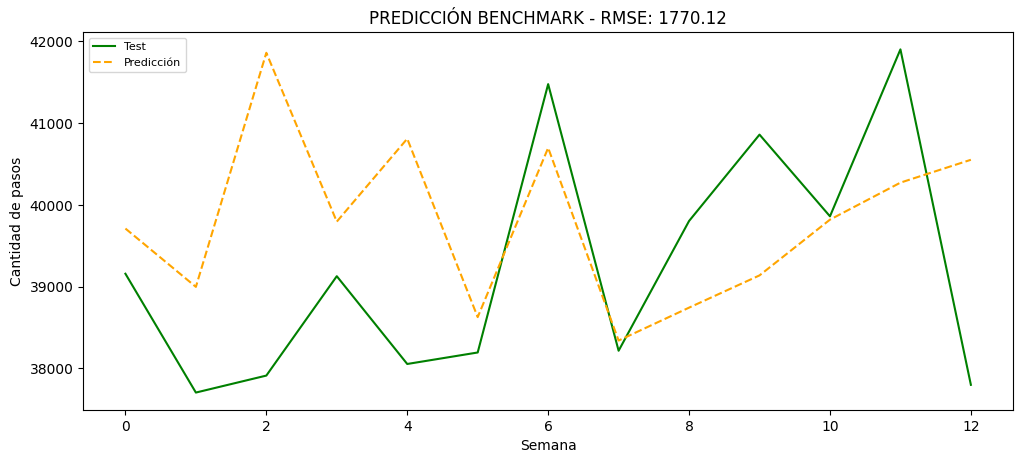

In [ ]:
# Gráfico out of sample
# ==============================================================================
plt.figure(figsize=(12,5),dpi = 100)
plt.plot(Y.values, label = 'Test', color='green')
plt.plot(Y_t.values, color = 'orange', label = 'Predicción', ls = '--')
plt.title('PREDICCIÓN BENCHMARK - RMSE: ' + str(round(rmse_benchmark,2)))
plt.xlabel('Semana')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

BENCHMARK REGRESIÓN LINEAL

In [ ]:
X

cantidad_pasos
fecha                     
2019-07-07    39711.142857
2019-07-14    38997.857143
2019-07-21    41860.857143
2019-07-28    39795.571429
2019-08-04    40810.000000
2019-08-11    38627.857143
2019-08-18    40698.000000
2019-08-25    38341.571429
2019-09-01    38743.857143
2019-09-08    39138.142857
2019-09-15    39820.142857
2019-09-22    40272.714286
2019-09-29    40552.285714

In [ ]:
# Nuevo dataset semanal para análisis gráfico
X['fecha_numeros']= X.index.map(datetime.datetime.toordinal)
X.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


cantidad_pasos  fecha_numeros
fecha                                    
2019-07-07    39711.142857         737247
2019-07-14    38997.857143         737254
2019-07-21    41860.857143         737261
2019-07-28    39795.571429         737268
2019-08-04    40810.000000         737275

In [ ]:
# Regresión lineal para benchmark
# ==============================================================================
lr = LinearRegression()
lr.fit(X.fecha_numeros.values.reshape(-1, 1), X.cantidad_pasos)
fc_lineal = lr.predict(X.fecha_numeros.values.reshape(-1, 1))
rmse_lineal = np.sqrt(mean_squared_error(Y,fc_lineal))
mape_lineal = mean_absolute_percentage_error(Y,fc_lineal)*100

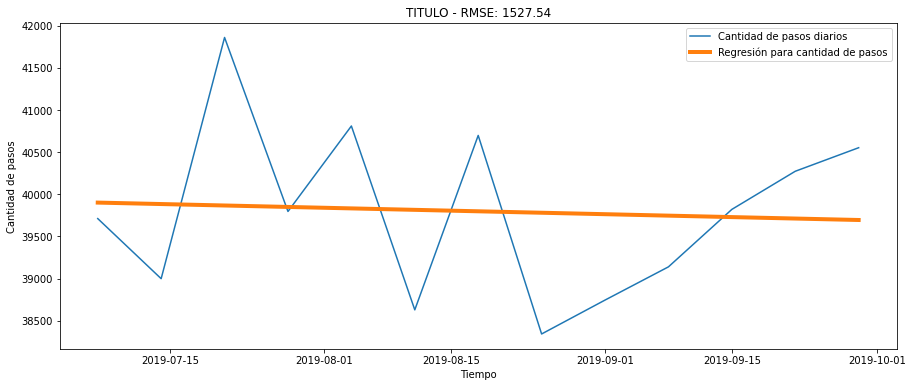

In [ ]:
# Dataset Semanal con media móvil y tendencia
# ==============================================================================
plt.figure(figsize = (15,6))
plt.plot(X.index, X.cantidad_pasos,label = 'Cantidad de pasos diarios')
plt.plot(X.index, fc_lineal, lw = 4, label = 'Regresión para cantidad de pasos')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.title('TITULO - RMSE: '+ str(round(rmse_lineal,2)))
plt.legend()
plt.show()

#Forecasting SEMANAL

##Serie estacionaria. Test Dickey-Fuller

Hacemos la prueba de Dickey-Fuller para confirmar si la serie es estacionaria. Un p-value menor a 0.05 rechaza la hipotesis nula, por lo tanto la serie es estacionaria. En caso contrario la serie no es estacionaria. 

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
resultado_adfuller = adfuller(semanal.cantidad_pasos)
print('ADF statics = %f' % resultado_adfuller[0])
print('p-value: %f' % resultado_adfuller[1])

ADF statics = -1.842821
p-value: 0.359419


El metodo adfuller() nos da un p-value mayor a 0.05 para la serie de datos semanal, por lo que consideramos que no es estacionaria. Procedemos a obtener la primera diferencia. 

In [ ]:
#SEMANAL
resultado_adfuller = adfuller(semanal.cantidad_pasos.diff().dropna())
print('ADF statics = %f' % resultado_adfuller[0])
print('p-value: %f' % resultado_adfuller[1])

ADF statics = -9.837958
p-value: 0.000000


Luego de aplicar el metodo adfuller() a la diferencia de la serie de tiempo semanal, obtenemos un p-value menor a 0.05, por lo que resolvemor que con la primera diferencia la serie de tiempo es estacionaria. 

Confirmaremos ahora con análisis gráfico de Autocorrelación y Autocorrelación parcial. También obtendremos AIC y otros parametros para preparar la serie de tiempos y obtener las predicciones

In [ ]:
# Comenzamos calculando el número de diferencias necesarias para el modelo ARIMA: 
from pmdarima.arima.utils import ndiffs
print('Número de diferencias: ', ndiffs(semanal, test='adf'))

Número de diferencias:  1


In [ ]:
logClose = np.log(semanal)
print('Número de diferencias en transformación logaritmica: ', ndiffs(logClose[1:] , test='adf'))

Número de diferencias en transformación logaritmica:  1


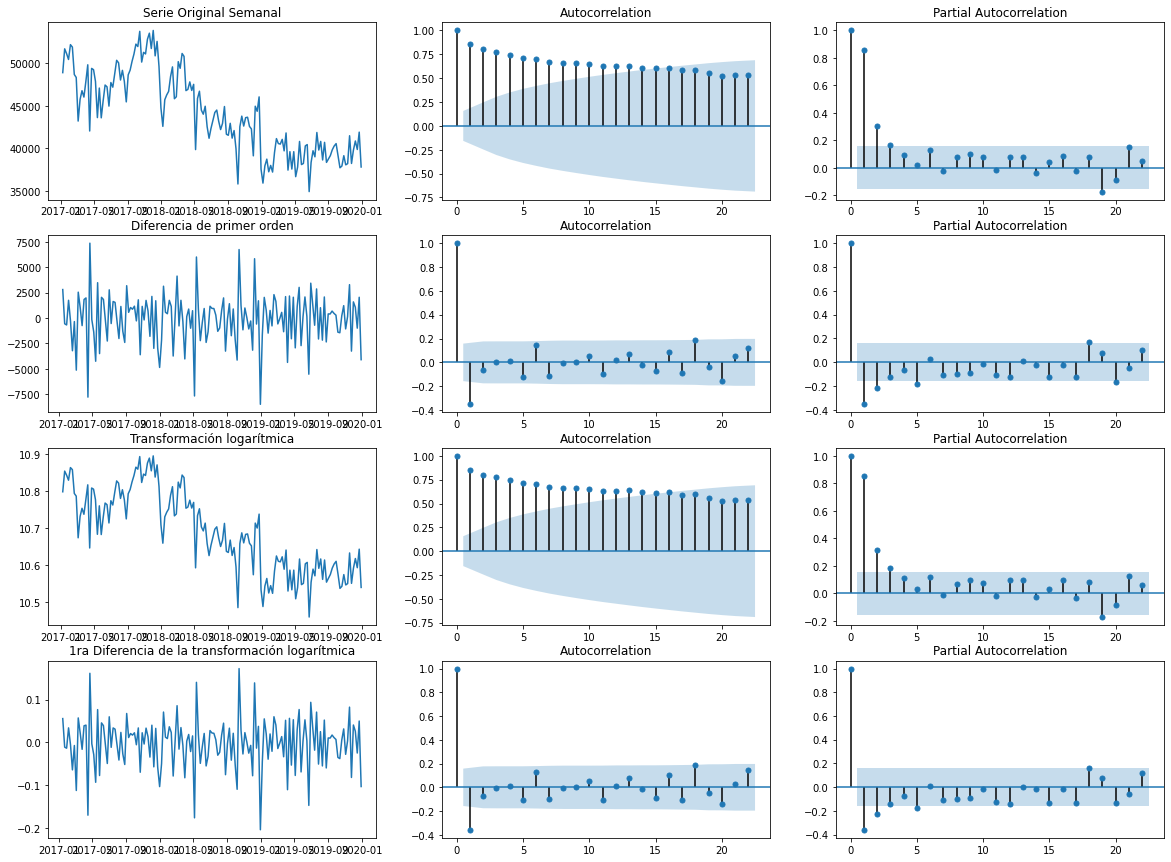

In [ ]:
# Gráfico autocorrelaciones semanal
# ==============================================================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(4,3, figsize=(20, 15))
#fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(semanal.cantidad_pasos); axes[0, 0].set_title('Serie Original Semanal')
plot_acf(semanal.cantidad_pasos, ax=axes[0, 1])
plot_pacf(semanal.cantidad_pasos, ax=axes[0, 2])

axes[1, 0].plot(semanal.cantidad_pasos.diff()); axes[1, 0].set_title('Diferencia de primer orden')
plot_acf(semanal.cantidad_pasos.diff().dropna(), ax=axes[1, 1])
plot_pacf(semanal.cantidad_pasos.diff().dropna(), ax=axes[1, 2])

axes[2, 0].plot(np.log(semanal.cantidad_pasos)); axes[2, 0].set_title('Transformación logarítmica')
plot_acf(np.log(semanal.cantidad_pasos).dropna(), ax=axes[2, 1])
plot_pacf(np.log(semanal.cantidad_pasos).dropna(), ax=axes[2, 2])

axes[3, 0].plot(np.log(semanal.cantidad_pasos).diff()); axes[3, 0].set_title('1ra Diferencia de la transformación logarítmica')
plot_acf(np.log(semanal.cantidad_pasos).diff().dropna(), ax=axes[3, 1])
plot_pacf(np.log(semanal.cantidad_pasos).diff().dropna(), ax=axes[3, 2])

plt.show()

**Gráfico original**: Podemos observar en el gráfico original que la serie no se condice una estacionaria. En la Autocorrelación vemos que el comportamiento de los lags es descendiente y gran parte se encuentra fuera del intervalo de confianza. Por lo que procedemos a observar la Primera Diferencia. 

**Primera diferencia**: En este gráfico observamos que los valores suceden con una media cercana a cero, lo que sugiere una serie más estacionaria, al igual que los lags en el gráfico de autocorrelación. 

**Transformación logarítmica**: En el gráfico de la transformación y de la autocorrelación se observan parametros que no se condicen con una serie estacionaria. 

**Primera diferencia de la transformación logarítmica**: En este gráfico observamos que los valores suceden con una media cercana a cero, lo que sugiere una serie más estacionaria, al igual que los lags en el gráfico de autocorrelación.

## Train Test Semanal

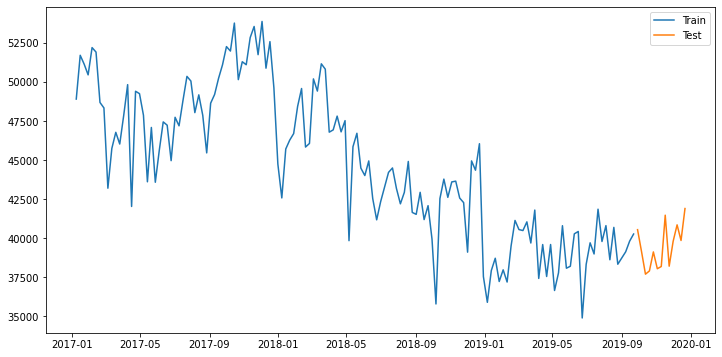

In [ ]:
# Gráfico Train Test Semanal
# ==============================================================================
plt.figure(figsize=(12,6))
semanas = 13
train = semanal[:-1].cantidad_pasos[:-semanas]
test = semanal[:-1].cantidad_pasos[-semanas:]
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend()
plt.show()

In [ ]:
# Creo un dataframe para acumular las predicciones
resultados_test = pd.DataFrame(test)
resultados_test.rename(columns = {'cantidad_pasos':'Real'}, inplace = True) 
# Agregamos los resultados del Benchmark
resultados_test['Benchmark'] = Y_t.values
resultados_test

Real     Benchmark
fecha                                 
2019-09-29  40552.285714  39711.142857
2019-10-06  39158.428571  38997.857143
2019-10-13  37705.142857  41860.857143
2019-10-20  37912.857143  39795.571429
2019-10-27  39128.428571  40810.000000
2019-11-03  38054.714286  38627.857143
2019-11-10  38195.285714  40698.000000
2019-11-17  41477.571429  38341.571429
2019-11-24  38216.714286  38743.857143
2019-12-01  39803.571429  39138.142857
2019-12-08  40860.071429  39820.142857
2019-12-15  39860.714286  40272.714286
2019-12-22  41902.571429  40552.285714

### Autoarima semanal

### ARIMA Out of sample

In [ ]:
# Función que obtiene la primera diferenia del dataset
# ==============================================================================
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)
 
# Función que invierte la diferencia. 
# ==============================================================================
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [ ]:
# Predicción ARIMA Out of sample semanal
# ==============================================================================
# Cargo dataset
series = train
# Obtengo la primera diferencia
X = series.values
weeks_in_year = 52
differenced = difference(X, weeks_in_year)

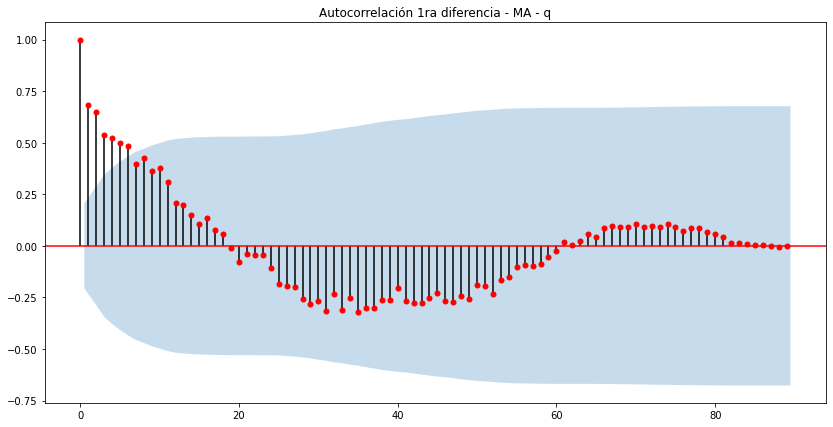

In [ ]:
# Obtenemos q
# ==============================================================================
fig, ejes = plt.subplots(figsize=(14,7))
plot_acf(differenced, lags = len(differenced)-1,ax=ejes,color="red",use_vlines=True, title='Autocorrelación 1ra diferencia - MA - q')    
plt.show()

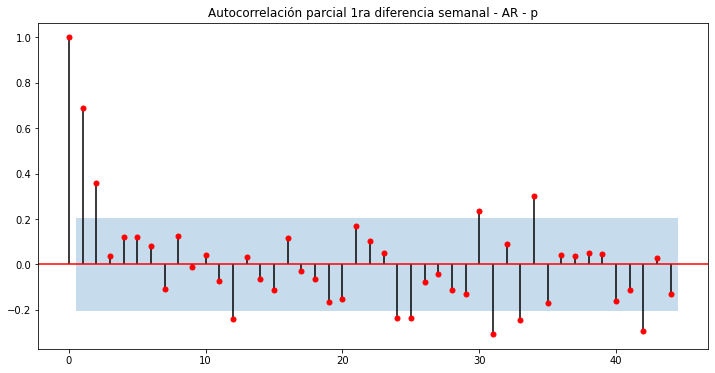

In [ ]:
# Ahora vemos que ocurre con la ACF 1ra diferencia.
# ==============================================================================
Nlags= 44
pacf1_semanal= pacf(differenced, nlags= Nlags)
pacf1_semanal.shape

fig, ejes = plt.subplots(figsize=(12,6))
plot_pacf(differenced,lags=Nlags,ax=ejes,color="red", title='Autocorrelación parcial 1ra diferencia semanal - AR - p')
plt.show()

In [ ]:
# AUTOARIMA SEMANAL
model_w = auto_arima(differenced, start_p=1, start_q=1, # p y q inicial
                      test='adf',       
                      max_p=5, max_q=6, # p y q máximo
                      m=1,              
                      d=0,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_w.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1696.650, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1842.609, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1713.641, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1790.718, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1698.514, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1698.408, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1755.335, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1698.644, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1698.753, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1696.913, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.718 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(1, 0, 1)   Log Likelihood        

En el summary() obtengo los indicadores SARIMAX Results. 

**|Z| > 1.96** => Relevante (la elegimos)

**"P>|Z|" < 0.05** => Relevante (la elegimos)

**[ - ] Incluye el cero** => No Relevante (no la elegimos)

**AIC** => Buscamos el menor valor



In [ ]:
# Entrenamos el modelo con p y q obtenidos con autoarima
model = ARIMA(differenced, order=(1,0,1))
model_fit = model.fit()
# Predicción multi-step out-of-sample
start_index = len(differenced)
end_index = start_index + 12
forecast = model_fit.predict(start=start_index, end=end_index)
# Invierto la diferencia para comparar
history = [x for x in X]
week = 1
bold('Predicción semanal para el último trimestre de 2019:')
for yhat in forecast:
	inverted = inverse_difference(history, yhat, weeks_in_year)
	print('Semana %d: %f' % (week, inverted))
	history.append(inverted)
	week += 1

Predicción semanal para el último trimestre de 2019:
Semana 1: 37292.743739
Semana 2: 32929.053712
Semana 3: 39467.484931
Semana 4: 40529.079139
Semana 5: 39194.514703
Semana 6: 40027.166379
Semana 7: 39936.094651
Semana 8: 38727.750267
Semana 9: 38315.679599
Semana 10: 35040.016485
Semana 11: 40777.831911
Semana 12: 40092.698611
Semana 13: 41705.256248


In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   90
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -843.630
Date:                Sat, 02 Oct 2021   AIC                           1695.259
Time:                        00:18:42   BIC                           1705.258
Sample:                             0   HQIC                          1699.292
                                 - 90                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5228.0491   1962.774     -2.664      0.008   -9075.016   -1381.082
ar.L1          0.9147      0.046     19.987      0.000       0.825       1.004
ma.L1         -0.4991      0.100     -4.988      0.0

In [ ]:
resultados_test['fc_arima_oos'] = history[-13:]
resultados_test

Real     Benchmark  fc_arima_oos
fecha                                               
2019-09-29  40552.285714  39711.142857  37292.743739
2019-10-06  39158.428571  38997.857143  32929.053712
2019-10-13  37705.142857  41860.857143  39467.484931
2019-10-20  37912.857143  39795.571429  40529.079139
2019-10-27  39128.428571  40810.000000  39194.514703
2019-11-03  38054.714286  38627.857143  40027.166379
2019-11-10  38195.285714  40698.000000  39936.094651
2019-11-17  41477.571429  38341.571429  38727.750267
2019-11-24  38216.714286  38743.857143  38315.679599
2019-12-01  39803.571429  39138.142857  35040.016485
2019-12-08  40860.071429  39820.142857  40777.831911
2019-12-15  39860.714286  40272.714286  40092.698611
2019-12-22  41902.571429  40552.285714  41705.256248

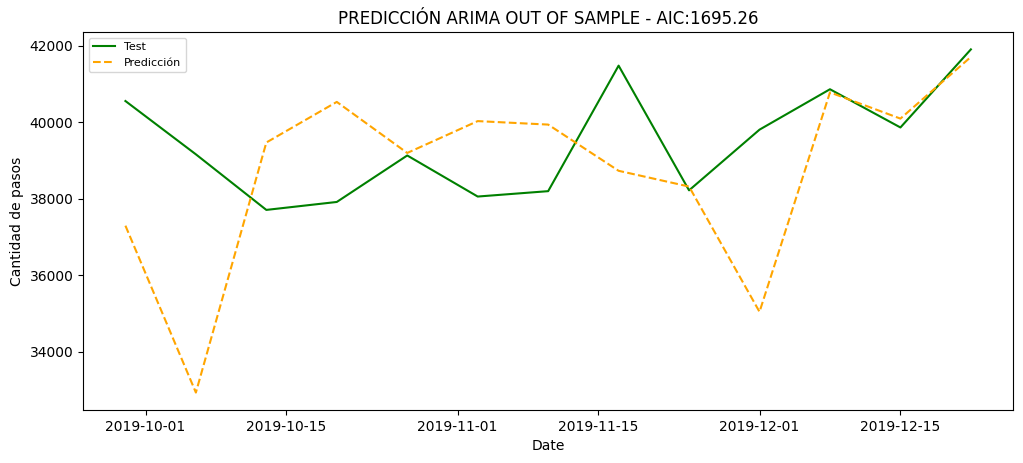

In [ ]:
# Gráfico out of sample
# ==============================================================================
plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test, label = 'Test', color='green')
plt.plot(resultados_test.fc_arima_oos, color = 'orange', label = 'Predicción', ls = '--')
plt.title('PREDICCIÓN ARIMA OUT OF SAMPLE - AIC:'+ str(round(model_fit.aic,2)))
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [ ]:
# Error Arima Out of Sample Semanal
# ==============================================================================
rmse_arima_oos = np.sqrt(mean_squared_error(test, resultados_test.fc_arima_oos))
mape_arima_oos = mean_absolute_percentage_error(test, resultados_test.fc_arima_oos)*100

print(f"RMSE ARIMA OUT OF SAMPLE: ", rmse_arima_oos)
print(f"MAPE ARIMA OUT OF SAMPLE: ", mape_arima_oos)

RMSE ARIMA OUT OF SAMPLE:  2726.9004966087446
MAPE ARIMA OUT OF SAMPLE:  5.041600691016355


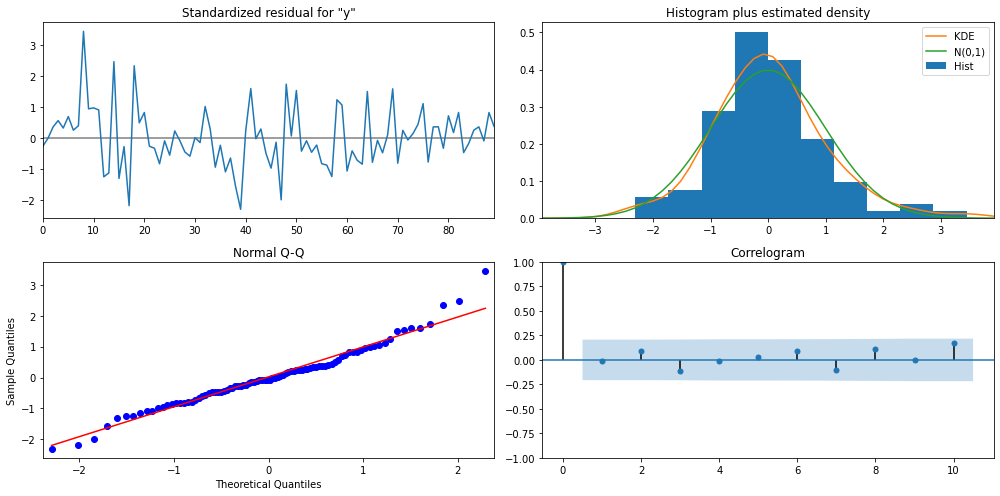

In [ ]:
# Análisis Residuos
# ==============================================================================
model_fit.plot_diagnostics(figsize=(14,7))
plt.tight_layout()
plt.show()

Arriba a la izquierda: los errores residuales parecen fluctuar alrededor de una media de cero y tienen una varianza uniforme.

Arriba a la derecha: la gráfica de densidad sugiere una distribución normal con media cero.

Abajo a la izquierda: todos los puntos deben estar perfectamente alineados con la línea roja. Cualquier desviación significativa implicaría que la distribución está sesgada.

Abajo a la derecha: el correlograma, también conocido como gráfico ACF, muestra que los errores residuales no están autocorrelacionados. Cualquier autocorrelación implicaría que existe algún patrón en los errores residuales que no se explican en el modelo. Por lo tanto, deberá buscar más X (predictores) en el modelo.

### Autoarima SARIMA

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = auto_arima(differenced, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=6, m=52,
                         start_P=0, seasonal=True,
                         d=0, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=1692.197, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1759.221, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1700.271, Time=0.58 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=2.56 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1842.609, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=1696.913, Time=0.03 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=1688.523, Time=4.78 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=1690.746, Time=0.82 sec
 ARIMA(1,0,1)(2,0,1)[52] intercept   : AIC=inf, Time=15.25 sec
 ARIMA(1,0,1)(1,0,2)[52] intercept   : AIC=inf, Time=17.28 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=inf, Time=14.20 sec
 ARIMA(1,0,1)(2,0,0)[52] intercept   : AIC=1692.725, Time=4.71 sec
 ARIMA(1,0,1)(2,0,2)[52] intercept   : AIC=inf, Time=22.83 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=1736.740, Time=0.88 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : A

### SARIMA Out of sample

In [ ]:
# Predicción SARIMA Out of sample semanal
# Cargo dataset
series = train
# Obtengo la primera diferencia
X = series.values
weeks_in_year = 52
differenced = difference(X, weeks_in_year)

# Entreno modelo con p, q y d obtenidos
model = SARIMAX(differenced, order=(1,0,1), seasonal_order=(1,0,1,52))
model_fit = model.fit()
# Predicción multi-step out-of-sample
start_index = len(differenced)
end_index = start_index + 12
forecast = model_fit.predict(start=start_index, end=end_index)
# Invierto la diferencia para comparar
history = [x for x in X]
week = 1
bold('Predicción semanal para el último trimestre de 2019:')
for yhat in forecast:
	inverted = inverse_difference(history, yhat, weeks_in_year)
	print('Semana %d: %f' % (week, inverted))
	history.append(inverted)
	week += 1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Predicción semanal para el último trimestre de 2019:
Semana 1: 40079.698701
Semana 2: 37980.626707
Semana 3: 42279.270931
Semana 4: 41128.350788
Semana 5: 41217.792711
Semana 6: 41684.161703
Semana 7: 42671.096685
Semana 8: 42583.000795
Semana 9: 41599.468441
Semana 10: 41205.515579
Semana 11: 42628.497937
Semana 12: 43280.396535
Semana 13: 42685.786308


In [ ]:
resultados_test['fc_sarima_oos'] = history[-13:]
resultados_test

Real     Benchmark  fc_arima_oos  fc_sarima_oos
fecha                                                              
2019-09-29  40552.285714  39711.142857  37292.743739   40079.698701
2019-10-06  39158.428571  38997.857143  32929.053712   37980.626707
2019-10-13  37705.142857  41860.857143  39467.484931   42279.270931
2019-10-20  37912.857143  39795.571429  40529.079139   41128.350788
2019-10-27  39128.428571  40810.000000  39194.514703   41217.792711
2019-11-03  38054.714286  38627.857143  40027.166379   41684.161703
2019-11-10  38195.285714  40698.000000  39936.094651   42671.096685
2019-11-17  41477.571429  38341.571429  38727.750267   42583.000795
2019-11-24  38216.714286  38743.857143  38315.679599   41599.468441
2019-12-01  39803.571429  39138.142857  35040.016485   41205.515579
2019-12-08  40860.071429  39820.142857  40777.831911   42628.497937
2019-12-15  39860.714286  40272.714286  40092.698611   43280.396535
2019-12-22  41902.571429  40552.285714  41705.256248   42685.786308

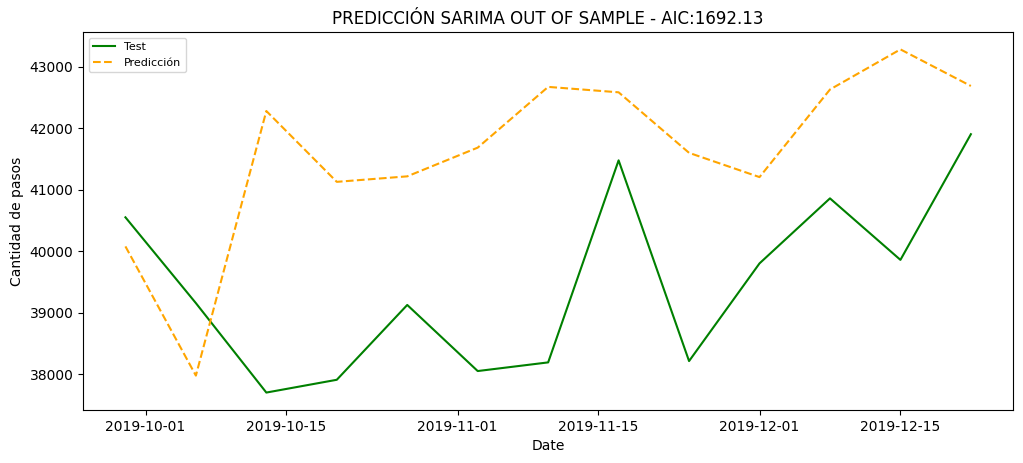

In [ ]:
# Gráfico out of sample
# ==============================================================================
plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test, label = 'Test', color='green')
plt.plot(resultados_test.fc_sarima_oos, color = 'orange', label = 'Predicción', ls = '--')
plt.title('PREDICCIÓN SARIMA OUT OF SAMPLE - AIC:'+ str(round(model_fit.aic,2)))
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [ ]:
# Error Sarima Out of Sample Semanal
# ==============================================================================
rmse_sarima_oos = np.sqrt(mean_squared_error(resultados_test.Real, resultados_test.fc_sarima_oos))
mape_sarima_oos = mean_absolute_percentage_error(resultados_test.Real, resultados_test.fc_sarima_oos)*100

print(f"RMSE SARIMA OUT OF SAMPLE: ", rmse_sarima_oos)
print(f"MAPE SARIMA OUT OF SAMPLE: ", mape_sarima_oos)

RMSE SARIMA OUT OF SAMPLE:  2780.554031109368
MAPE SARIMA OUT OF SAMPLE:  6.24586063231278


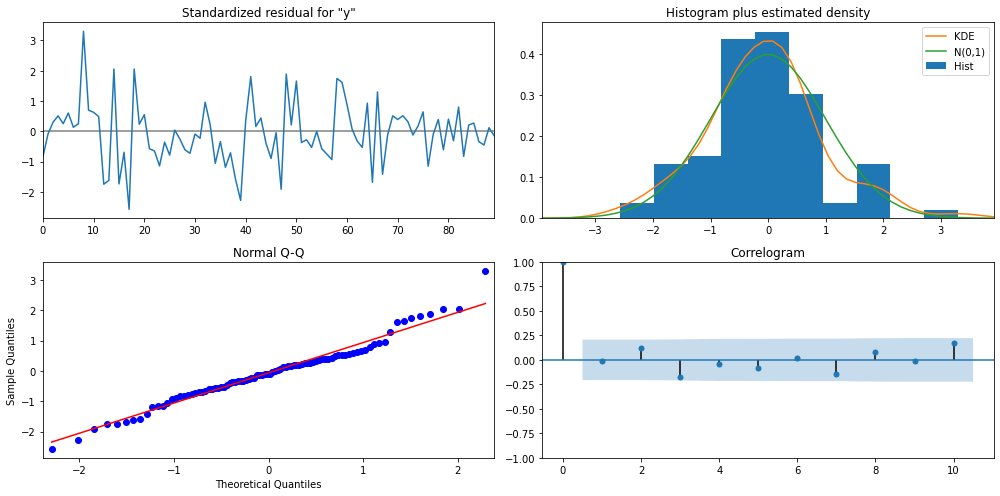

In [ ]:
# Gráfico errores
# ==============================================================================
model_fit.plot_diagnostics(figsize=(14,7))
plt.tight_layout()
plt.show()

Arriba a la izquierda: los errores residuales parecen fluctuar alrededor de una media de cero y tienen una varianza uniforme.

Arriba a la derecha: la gráfica de densidad muestra diferencias en la forma con la distribución normal con media cero.

Abajo a la izquierda: los puntos estan alineados al principio, pero se empiezan a separar en el último cuarto. Implicaría que la distribución está sesgada.

Abajo a la derecha: los errores residuales no están autocorrelacionados. Cualquier autocorrelación implicaría que existe algún patrón en los errores residuales que no se explican en el modelo. Por lo tanto, deberá buscar más X (predictores) en el modelo.

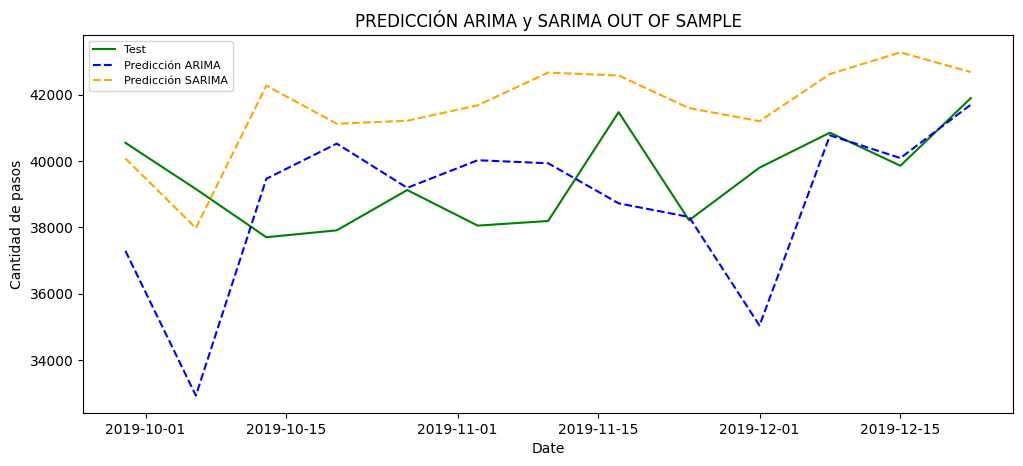

In [ ]:
# Gráfico out of sample ARIMA y SARIMA
# ==============================================================================
plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test, label = 'Test', color='green')
plt.plot(resultados_test.fc_arima_oos, color = 'blue', label = 'Predicción ARIMA', ls = '--')
plt.plot(resultados_test.fc_sarima_oos, color = 'orange', label = 'Predicción SARIMA', ls = '--')
plt.title('PREDICCIÓN ARIMA y SARIMA OUT OF SAMPLE')
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

Luego de hacer las predicciones con los metodos ARIMA y SARIMA en el dataset semanal obtenemos los siguientes datos: 

* ARIMA
  * AIC: 1696.65
  * RMSE: 2726
  * MAPE: 5.041
* SARIMA
  * AIC: 1688.52
  * RMSE: 2780.55
  * MAPE: 6.24.041

Vemos que los valores son similares en ambos modelos, pero nos quedamos con el modelo de ARIMA que tiene mejores valores en RMSE y MAPE, y el gráfico de errores tiene mejores indicadores. 

#Forecasting DIARIO

##Serie estacionaria. Test Dickey-Fuller

Hacemos la prueba de Dickey-Fuller para confirmar si la serie es estacionaria. Un p-value menor a 0.05 rechaza la hipotesis nula, por lo tanto la serie es estacionaria. En caso contrario la serie no es estacionaria. 



In [ ]:
#DIARIO
resultado_adfuller = adfuller(diario.cantidad_pasos)
print('ADF statics = %f' % resultado_adfuller[0])
print('p-value: %f' % resultado_adfuller[1])

ADF statics = -1.902620
p-value: 0.330829


El metodo adfuller() nos da un p-value mayor a 0.05 para la serie de datos diaria, por lo que consideramos que no es estacionaria. Procedemos a obtener la primera diferencia.

In [ ]:
resultado_adfuller = adfuller(diario.cantidad_pasos.diff().dropna())
print('ADF statics = %f' % resultado_adfuller[0])
print('p-value: %f' % resultado_adfuller[1])

ADF statics = -10.675498
p-value: 0.000000


Luego de aplicar el metodo adfuller() a la diferencia de la serie de tiempo diaria, obtenemos un p-value menor a 0.05, por lo que resolvemor que con la primera diferencia la serie de tiempo es estacionaria.

Confirmaremos ahora con análisis gráfico de Autocorrelación y Autocorrelación parcial. También obtendremos AIC y otros parametros para preparar la serie de tiempos y obtener las predicciones

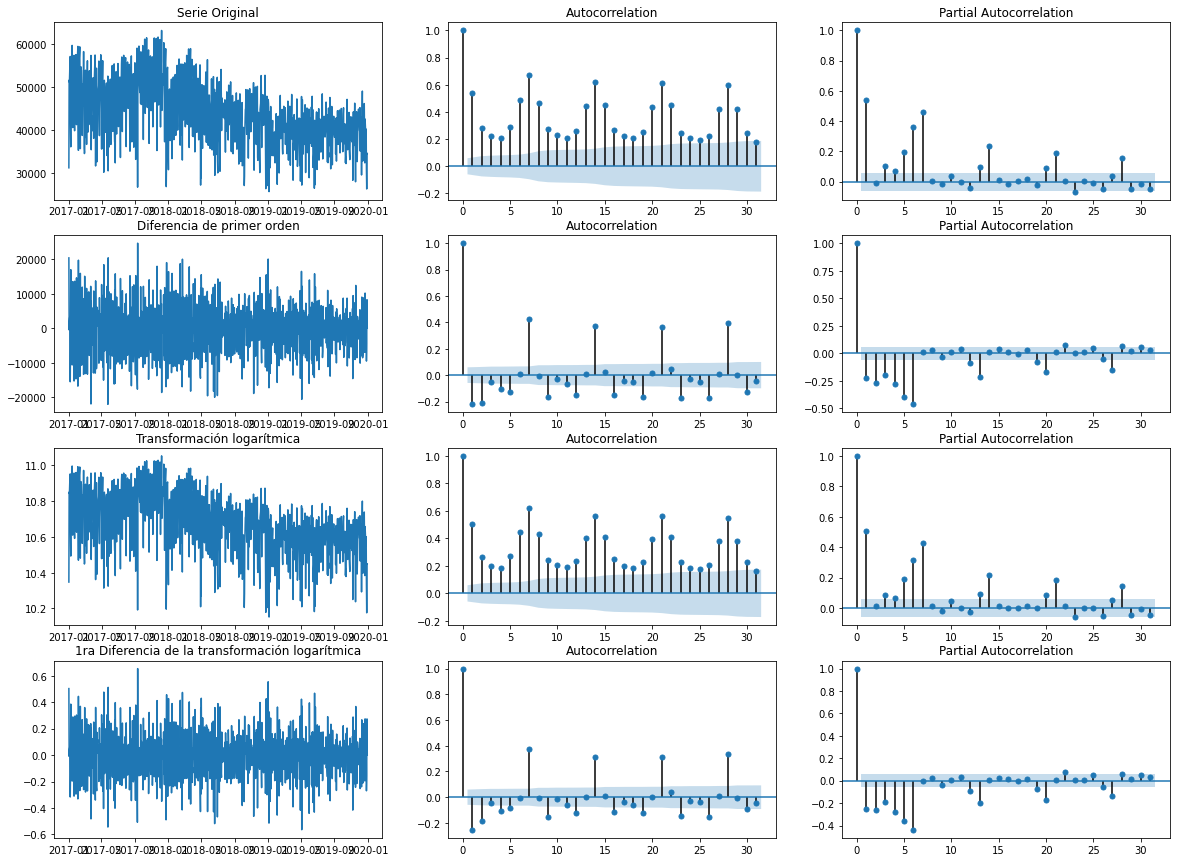

In [ ]:
# Gráficos Autocorrelaciones
# ==============================================================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(4,3, figsize=(20, 15))
#fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(diario.cantidad_pasos); axes[0, 0].set_title('Serie Original')
plot_acf(diario.cantidad_pasos, ax=axes[0, 1])
plot_pacf(diario.cantidad_pasos, ax=axes[0, 2])

axes[1, 0].plot(diario.cantidad_pasos.diff()); axes[1, 0].set_title('Diferencia de primer orden')
plot_acf(diario.cantidad_pasos.diff().dropna(), ax=axes[1, 1])
plot_pacf(diario.cantidad_pasos.diff().dropna(), ax=axes[1, 2])

axes[2, 0].plot(np.log(diario.cantidad_pasos)); axes[2, 0].set_title('Transformación logarítmica')
plot_acf(np.log(diario.cantidad_pasos).dropna(), ax=axes[2, 1])
plot_pacf(np.log(diario.cantidad_pasos).dropna(), ax=axes[2, 2])

axes[3, 0].plot(np.log(diario.cantidad_pasos).diff()); axes[3, 0].set_title('1ra Diferencia de la transformación logarítmica')
plot_acf(np.log(diario.cantidad_pasos).diff().dropna(), ax=axes[3, 1])
plot_pacf(np.log(diario.cantidad_pasos).diff().dropna(), ax=axes[3, 2])

plt.show()

## Train Test Diario

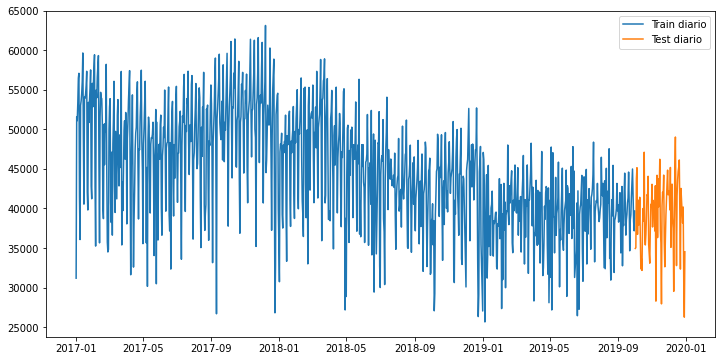

In [ ]:
# Gráfico Train Test Diario
# ==============================================================================
plt.figure(figsize=(12,6))
dias = 90
train_d = diario[:-1].cantidad_pasos[:-dias]
test_d = diario[:-1].cantidad_pasos[-dias:]
plt.plot(train_d, label='Train diario')
plt.plot(test_d, label='Test diario')
plt.legend()
plt.show()

In [ ]:
# Creo un dataframe para acumular las predicciones
resultados_test_d = pd.DataFrame(test_d)
resultados_test_d.rename(columns = {'cantidad_pasos':'Real'}, inplace = True) 
resultados_test_d

Real
fecha              
2019-10-02  34943.0
2019-10-03  35054.0
2019-10-04  43775.0
2019-10-05  45150.0
2019-10-06  36722.0
...             ...
2019-12-26  38168.0
2019-12-27  40182.0
2019-12-28  30681.0
2019-12-29  26259.0
2019-12-30  34523.0

[90 rows x 1 columns]

### Autoarima ARIMA

In [ ]:
# Predicción ARIMA Out of sample semanal
# Cargo dataset
series = train_d
# Obtengo la primera diferencia
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)

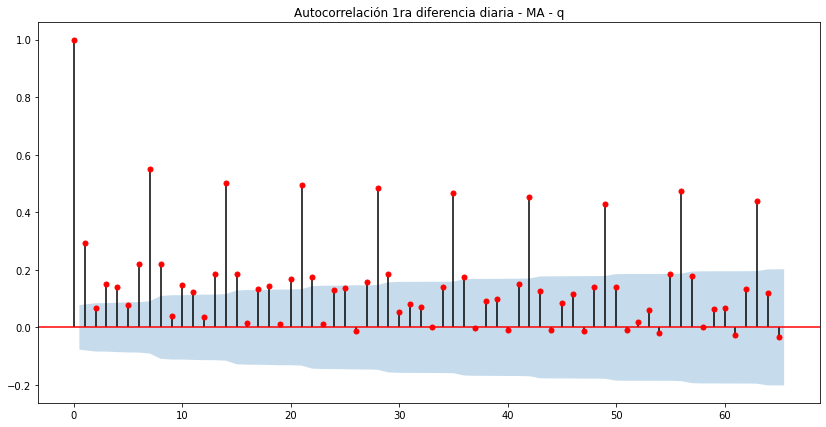

In [ ]:
# GRÁFICO AUTOCORRELACIÓN 1ra diferencia
fig, ejes = plt.subplots(figsize=(14,7))
plot_acf(differenced, lags = 65,ax=ejes,color="red",use_vlines=True, title='Autocorrelación 1ra diferencia diaria - MA - q')    
plt.show()

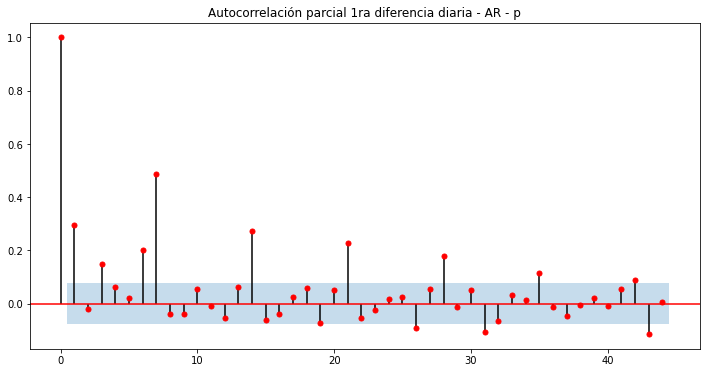

In [ ]:
# AUTOCORRELACIÓN PARCIAL 1ra diferencia.
Nlags= 44
pacf1_semanal= pacf(differenced, nlags= Nlags)
pacf1_semanal.shape

fig, ejes = plt.subplots(figsize=(12,6))
plot_pacf(differenced,lags=Nlags,ax=ejes,color="red", title='Autocorrelación parcial 1ra diferencia diaria - AR - p')
plt.show()

In [ ]:
# AUTOARIMA DIARIO
model = auto_arima(differenced, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=7, max_q=8, # maximum p and q
                      m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=13176.464, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13501.984, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13314.901, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=13361.506, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=13175.311, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13306.806, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=13162.177, Time=0.37 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=13264.878, Time=0.07 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=13162.054, Time=0.60 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=13253.728, Time=0.09 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=13157.465, Time=0.73 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=13250.537, Time=0.12 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=13125.252, Time=0.50 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=13211.051, Time=0.18 sec
 ARIMA(7,0,1)(0,0,0

### ARIMA Out of sample

In [ ]:
# Entreno modelo con p y q obtenidos
model = ARIMA(differenced, order=(7,0,0))
model_fit = model.fit()

# Predicción multi-step out-of-sample
start_index = len(differenced)
end_index = start_index + 90
forecast = model_fit.predict(start=start_index, end=end_index)

# Invierto la diferencia para comparar
history = [x for x in X]
day = 1
bold('Predicción diaria para el último trimestre de 2019:')
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Día %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Predicción diaria para el último trimestre de 2019:
Día 1: 37934.553122
Día 2: 38873.953179
Día 3: 33810.698392
Día 4: 35299.431671
Día 5: 28794.182468
Día 6: 31071.054837
Día 7: 38582.939192
Día 8: 39824.020557
Día 9: 42419.489264
Día 10: 42519.969251
Día 11: 46279.654622
Día 12: 47693.262860
Día 13: 43008.112296
Día 14: 37055.853822
Día 15: 42548.438216
Día 16: 41022.960024
Día 17: 42602.022876
Día 18: 45912.585909
Día 19: 37436.845083
Día 20: 31341.011519
Día 21: 39231.036187
Día 22: 40178.003493
Día 23: 34536.869953
Día 24: 43852.272693
Día 25: 45838.944312
Día 26: 41032.557823
Día 27: 36900.603539
Día 28: 38673.884830
Día 29: 35777.958482
Día 30: 40614.900961
Día 31: 41808.446092
Día 32: 44346.681343
Día 33: 40918.332193
Día 34: 38141.593089
Día 35: 39924.949453
Día 36: 40354.874114
Día 37: 40806.099696
Día 38: 42902.879183
Día 39: 46639.386899
Día 40: 27847.812604
Día 41: 26433.789369
Día 42: 36718.582786
Día 43: 34851.362475
Día 44: 41997.443488
Día 45: 44277.837075
Día 46: 4542

In [ ]:
resultados_test_d['fc_arima_oos'] = history[-90:]
resultados_test_d

Real  fc_arima_oos
fecha                            
2019-10-02  34943.0  38873.953179
2019-10-03  35054.0  33810.698392
2019-10-04  43775.0  35299.431671
2019-10-05  45150.0  28794.182468
2019-10-06  36722.0  31071.054837
...             ...           ...
2019-12-26  38168.0  40886.091414
2019-12-27  40182.0  42784.556867
2019-12-28  30681.0  30395.800861
2019-12-29  26259.0  27590.751883
2019-12-30  34523.0  24784.138994

[90 rows x 2 columns]

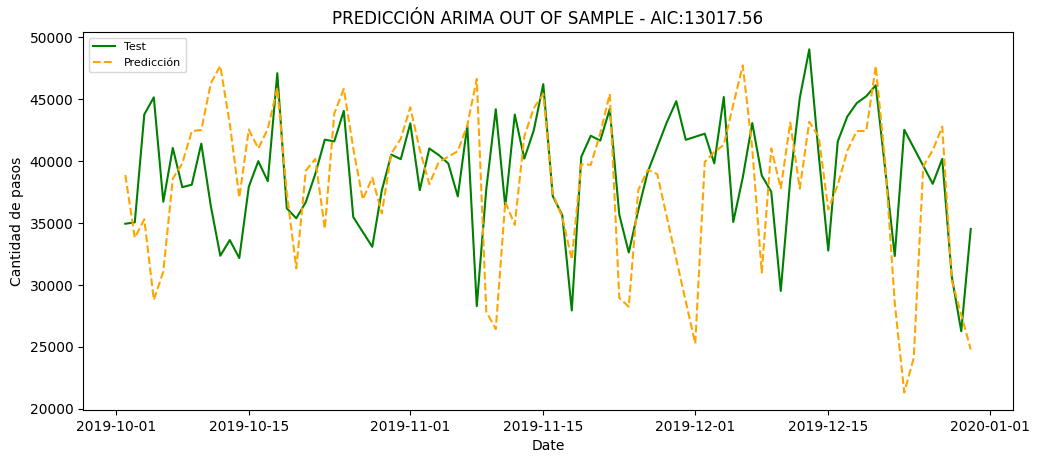

In [ ]:
# Gráfico out of sample
# ==============================================================================
plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test_d, label = 'Test', color='green')
plt.plot(resultados_test_d.fc_arima_oos, color = 'orange', label = 'Predicción', ls = '--')
plt.title('PREDICCIÓN ARIMA OUT OF SAMPLE - AIC:'+ str(round(model_fit.aic,2)))
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [ ]:
# Error Arima Out of Sample Diario
# ==============================================================================
rmse_arima_oos_d = np.sqrt(mean_squared_error(resultados_test_d.Real, resultados_test_d.fc_arima_oos))
mape_arima_oos_d = mean_absolute_percentage_error(resultados_test_d.Real, resultados_test_d.fc_arima_oos)*100

print(f"RMSE ARIMA OUT OF SAMPLE: ", rmse_arima_oos_d)
print(f"MAPE ARIMA OUT OF SAMPLE: ", mape_arima_oos_d)

RMSE ARIMA OUT OF SAMPLE:  6720.567545564324
MAPE ARIMA OUT OF SAMPLE:  12.263601503098204


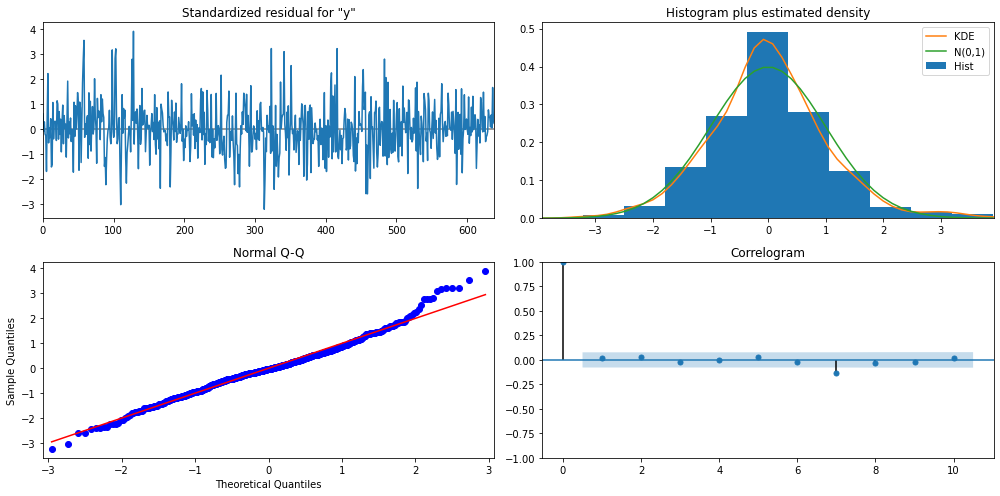

In [ ]:
# Análisis Residuos
# ==============================================================================
model_fit.plot_diagnostics(figsize=(14,7))
plt.tight_layout()
plt.show()

Arriba a la izquierda: los errores residuales parecen fluctuar alrededor de una media de cero y tienen una varianza uniforme.

Arriba a la derecha: la gráfica de densidad es similar a una distribución normal con media cero, con mayor acumulación en los valores cercanos a cero.

Abajo a la izquierda: los puntos estan alineados con la línea roja, exepto en la parte final de la recta. 

Abajo a la derecha: existe algún patrón en los errores residuales que no se explican en el modelo. 

### Autoarima SARIMA

In [ ]:
# Seasonal - fit stepwise auto-SARIMA - Diario
smodel = auto_arima(differenced, start_p=1, start_q=1,
                         test='adf',
                         max_p=7, max_q=7, m=7,
                         start_P=0, seasonal=True,
                         d=0, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=13114.310, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13275.534, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=13030.183, Time=0.64 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=13116.238, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13501.984, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=13219.948, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=13052.585, Time=0.79 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=13075.690, Time=0.51 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=13111.881, Time=0.15 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=13041.044, Time=1.60 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=13143.062, Time=0.16 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=13075.510, Time=0.35 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=13056.118, Time=0.33 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=13082.021, Time=0.23 sec
 ARIMA(2,0,1)(1,0,0

### SARIMA Out of sample

In [ ]:
# Predicción SARIMA Out of sample semanal
# ==============================================================================
# Cargo dataset
series = train_d
# Obtengo la primera diferencia
X = series.values
days_in_year = 365
differenced = difference(X, days_in_year)

# Entreno modelo con p, q y d obtenidos
model = SARIMAX(differenced, order=(1,0,0), seasonal_order=(1,0,0,7))
model_fit = model.fit()

# Predicción multi-step out-of-sample
start_index = len(differenced)
end_index = start_index + 90
forecast = model_fit.predict(start=start_index, end=end_index)

# Invierto la diferencia para comparar
history = [x for x in X]
day = 1
bold('Predicción diaria para el último trimestre de 2019:')
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Dia %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Predicción diaria para el último trimestre de 2019:
Dia 1: 38994.070162
Dia 2: 39594.089204
Dia 3: 35368.892254
Dia 4: 35745.626313
Dia 5: 31158.629551
Dia 6: 32503.068788
Dia 7: 39973.955848
Dia 8: 41802.893294
Dia 9: 44070.038685
Dia 10: 44991.663554
Dia 11: 47711.397092
Dia 12: 51080.058325
Dia 13: 45555.795086
Dia 14: 39440.992271
Dia 15: 45295.081150
Dia 16: 43530.991614
Dia 17: 45718.431101
Dia 18: 48285.472997
Dia 19: 41341.474523
Dia 20: 34668.567163
Dia 21: 42356.542270
Dia 22: 43529.519423
Dia 23: 37738.144557
Dia 24: 47461.356180
Dia 25: 48966.639117
Dia 26: 45250.369314
Dia 27: 40760.161156
Dia 28: 42349.896733
Dia 29: 39593.768591
Dia 30: 44344.588106
Dia 31: 45800.150832
Dia 32: 48041.089209
Dia 33: 45353.635120
Dia 34: 42366.094249
Dia 35: 44005.851926
Dia 36: 44521.264212
Dia 37: 44926.851733
Dia 38: 47189.251923
Dia 39: 50746.841959
Dia 40: 32446.242681
Dia 41: 30912.513155
Dia 42: 41094.330816
Dia 43: 39279.205818
Dia 44: 46403.144620
Dia 45: 48787.927485
Dia 46: 4982

In [ ]:
resultados_test_d['fc_sarima_oos'] = history[-90:]
resultados_test_d

Real  fc_arima_oos  fc_sarima_oos
fecha                                           
2019-10-02  34943.0  38873.953179   39594.089204
2019-10-03  35054.0  33810.698392   35368.892254
2019-10-04  43775.0  35299.431671   35745.626313
2019-10-05  45150.0  28794.182468   31158.629551
2019-10-06  36722.0  31071.054837   32503.068788
...             ...           ...            ...
2019-12-26  38168.0  40886.091414   45928.942792
2019-12-27  40182.0  42784.556867   47824.271392
2019-12-28  30681.0  30395.800861   35457.658549
2019-12-29  26259.0  27590.751883   32652.611705
2019-12-30  34523.0  24784.138994   29842.771984

[90 rows x 3 columns]

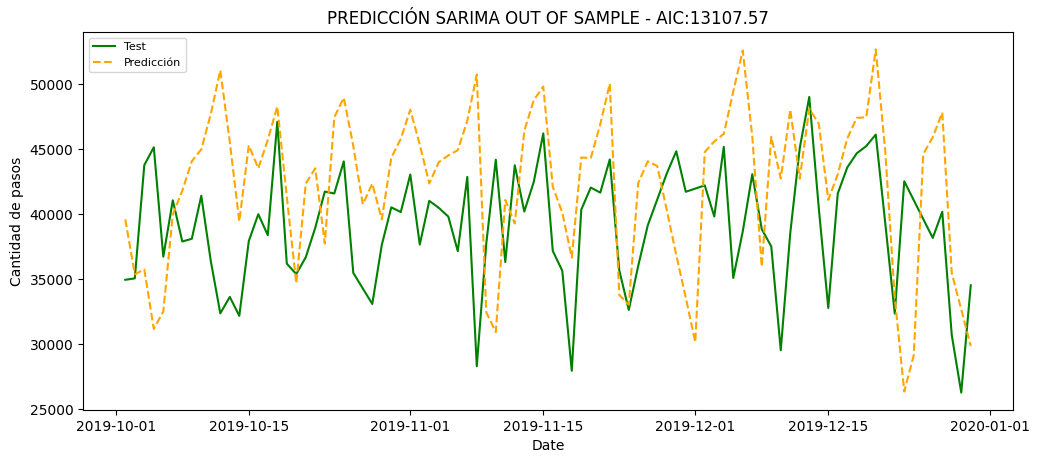

In [ ]:
# Gráfico out of sample
# ==============================================================================
plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test_d, label = 'Test', color='green')
plt.plot(resultados_test_d.fc_sarima_oos, color = 'orange', label = 'Predicción', ls = '--')
plt.title('PREDICCIÓN SARIMA OUT OF SAMPLE - AIC:'+ str(round(model_fit.aic,2)))
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

In [ ]:
# Error Sarima Out of Sample Diario
# ==============================================================================
rmse_sarima_oos_d = np.sqrt(mean_squared_error(resultados_test_d.Real, resultados_test_d.fc_sarima_oos))
mape_sarima_oos_d = mean_absolute_percentage_error(resultados_test_d.Real, resultados_test_d.fc_sarima_oos)*100

print(f"RMSE SARIMA OUT OF SAMPLE: ", rmse_sarima_oos_d)
print(f"RMSE SARIMA OUT OF SAMPLE: ", mape_sarima_oos_d)

RMSE SARIMA OUT OF SAMPLE:  7325.541680664292
RMSE SARIMA OUT OF SAMPLE:  16.16332204945659


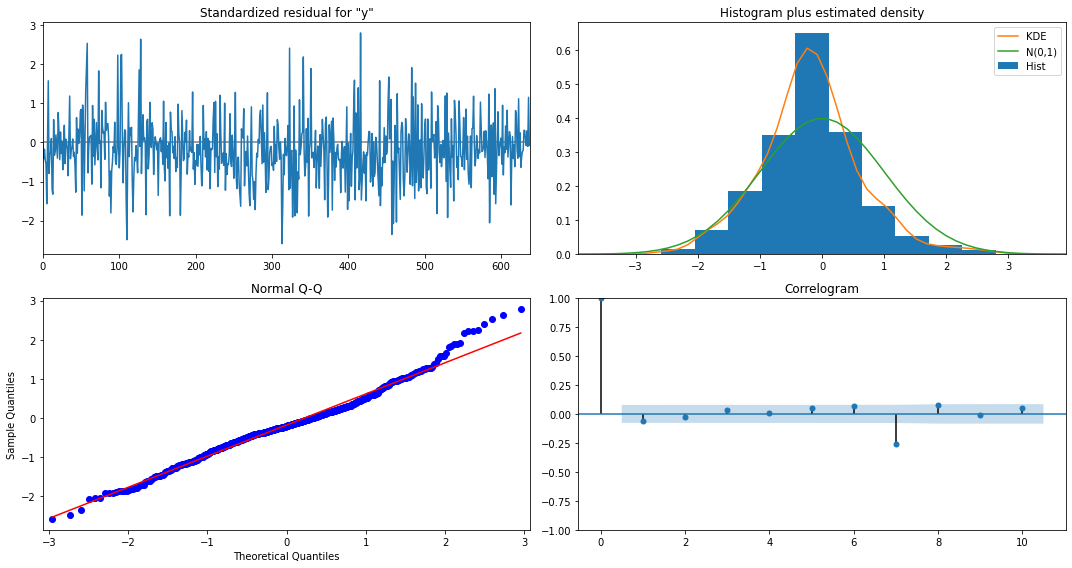

In [ ]:
# Análisis Residuos
# ==============================================================================
model_fit.plot_diagnostics(figsize=(15,8))
plt.tight_layout()
plt.show()

Arriba a la izquierda: los errores residuales parecen fluctuar alrededor de una media menor a cero y tienen una varianza uniforme.

Arriba a la derecha: la gráfica de densidad difiere a una distribución normal con media cero, con mayor acumulación en los valores menores a cero.

Abajo a la izquierda: los puntos estan alineados con la línea roja, exepto en la parte final de la recta. 

Abajo a la derecha: existe algún patrón en los errores residuales que no se explican en el modelo. 

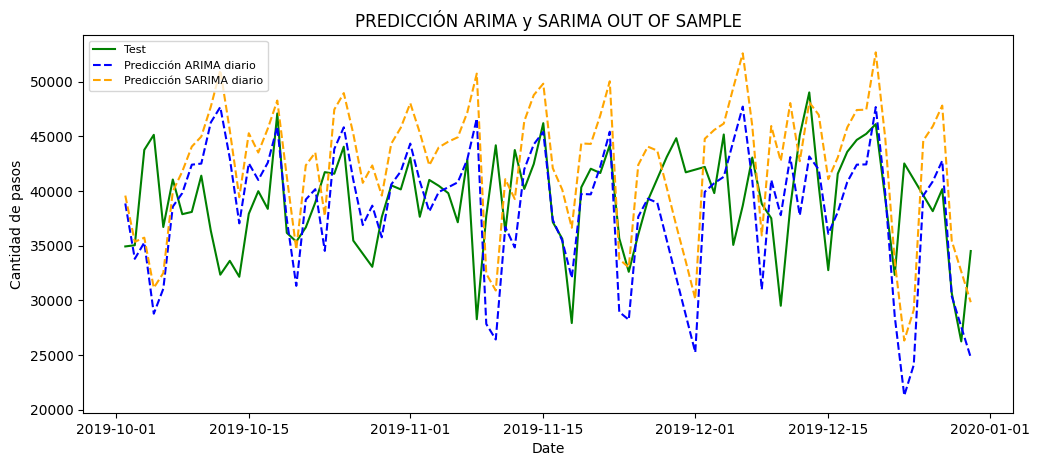

In [ ]:
# Gráfico out of sample ARIMA y SARIMA diario
# ==============================================================================
plt.figure(figsize=(12,5),dpi = 100)
plt.plot(test_d, label = 'Test', color='green')
plt.plot(resultados_test_d.fc_arima_oos, color = 'blue', label = 'Predicción ARIMA diario', ls = '--')
plt.plot(resultados_test_d.fc_sarima_oos, color = 'orange', label = 'Predicción SARIMA diario', ls = '--')
plt.title('PREDICCIÓN ARIMA y SARIMA OUT OF SAMPLE')
plt.xlabel('Date')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 8)
plt.show()

Luego de hacer las predicciones con los métodos ARIMA y SARIMA en el dataset diario obtenemos los siguientes datos: 

* ARIMA
 * AIC: 13017
 * RMSE: 6720
 * MAPE: 12.26
* SARIMA
 * AIC: 13030
 * RMSE: 7325
 * MAPE: 16.16

Vemos que el modelo de ARIMA tiene mejores valores en RMSE y MAPE, y el gráfico de errores tiene mejores indicadores. 

# Resultados ARIMA | SARIMA

In [ ]:
print('Semanal - RMSE BENCHMARK Media móvil: ', rmse_benchmark)
print('Semanal - RMSE BENCHMARK Regresión Lineal: ', rmse_lineal)
print('Semanal - RMSE ARIMA Out of sample: ', rmse_arima_oos)
print('Semanal - RMSE SARIMA Out of sample: ', rmse_sarima_oos)
print('')
print('Semanal - MAPE BENCHMARK Media móvil: ', mape_benchmark)
print('Semanal - MAPE BENCHMARK Regresión Lineal: ', mape_lineal)
print('Semanal - MAPE ARIMA Out of sample: ', mape_arima_oos)
print('Semanal - MAPE SARIMA Out of sample: ', mape_sarima_oos)
print('')
print('Diario - RMSE ARIMA Out of sample: ', rmse_arima_oos_d)
print('Diario - RMSE SARIMA Out of sample: ', rmse_sarima_oos_d)
print('')
print('Diario - MAPE ARIMA Out of sample: ', mape_arima_oos_d)
print('Diario - MAPE SARIMA Out of sample: ', mape_sarima_oos_d)

Semanal - RMSE BENCHMARK Media móvil:  1770.119235733209
Semanal - RMSE BENCHMARK Regresión Lineal:  1527.54497708734
Semanal - RMSE ARIMA Out of sample:  2726.9004966087446
Semanal - RMSE SARIMA Out of sample:  2780.554031109368

Semanal - MAPE BENCHMARK Media móvil:  3.514412714480027
Semanal - MAPE BENCHMARK Regresión Lineal:  3.4709464695866923
Semanal - MAPE ARIMA Out of sample:  5.041600691016355
Semanal - MAPE SARIMA Out of sample:  6.24586063231278

Diario - RMSE ARIMA Out of sample:  6720.567545564324
Diario - RMSE SARIMA Out of sample:  7325.541680664292

Diario - MAPE ARIMA Out of sample:  12.263601503098204
Diario - MAPE SARIMA Out of sample:  16.16332204945659


En principio, los modelos ARIMA y SARIMA out of sample dan buenos resultados, a pesar que los valores RMSE y MAPE son mejores en los modelos simples utilizados como Benchmark. 

También se observa de los valores de RMSE y MAPE son menores en la serie de tiempo semanal. 

[Artículo sobre AUTOARIMA con ARIMA y SARIMA](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

# XGBoost Regressor

Para utilizar este modelo de boosting vamos a dividir el dataset en X e Y para Train y Test, de modo de obtener los errores en la predicción, y saber si el modelo tiene overfiting. Aplicaremos optimización de hiperparametros con el método 

In [ ]:
# Ordenamos los datos para trabajar con el modelo XGBoost Regressor
data_XGB = semanal.cantidad_pasos

N = data_XGB.shape[0]
print(N)

156


In [ ]:
look_back = 12 # Numero de semanas anteriores para predecir el valor siguiente.

# Creamos la matriz de datos
X = np.zeros((N - look_back - 1, look_back))
Y = np.zeros(N - look_back - 1)

print(X.shape, Y.shape)

(143, 12) (143,)


In [ ]:
# Llenamos de datos la matriz
for i in range(X.shape[0]):
    X[i,:] = data_XGB.iloc[i:i+look_back]
    Y[i] = data_XGB.iloc[i+look_back]

In [ ]:
print('Tamaño de X: ', X.shape)
print('Tamaño de Y: ', Y.shape)

Tamaño de X:  (143, 12)
Tamaño de Y:  (143,)


In [ ]:
# Train, test, split
N_train = 144 - look_back        # Cantidad de semanas que uso para entrenar
N_test = 12                      # Cantidad de semanas que uso para evaluar.

N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
Y_train = Y[:N_train]
print(X_train.shape, Y_train.shape)

X_test = X[N_train:N_train+N_test,:]
Y_test = Y[N_train:N_train+N_test]
print(X_test.shape, Y_test.shape)

(132, 12) (132,)
(11, 12) (11,)


In [ ]:
# Entrenamiento
model_xgbr = XGBRegressor(objective= "reg:squarederror", eval_metric= 'rmse')
model_xgbr.fit(X_train, Y_train)

XGBRegressor(eval_metric='rmse', objective='reg:squarederror')

In [ ]:
# Cross validation
tss = TimeSeriesSplit(n_splits=2)

In [ ]:
# Obtenemos los mejores hiperparámetros
best_score_train = abs(cross_val_score(
    model_xgbr, X_train, Y_train, cv=tss, scoring="neg_root_mean_squared_error")
)
best_score_test = abs(cross_val_score(
    model_xgbr, X_test, Y_test, cv=tss,  scoring="neg_root_mean_squared_error"))

print("Mejor Score en Train (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_train.mean(), best_score_train.std()))

print("Mejor Score en Test (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_test.mean(), best_score_test.std()))

Mejor Score en Train (CV = 10) 2736.23 (+/- 294.25)
Mejor Score en Test (CV = 10) 2387.88 (+/- 185.59)


In [ ]:
# Predicción
Y_train_pred_xgb= model_xgbr.predict(X_train)
Y_test_pred_xgb= model_xgbr.predict(X_test)

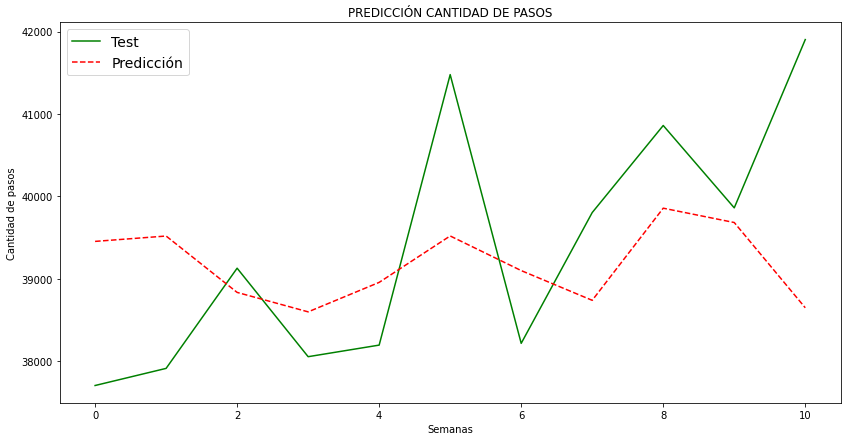

In [ ]:
# Gráfico
# ==============================================================================
plt.figure(figsize=(14,7))
plt.plot(Y_test, label = 'Test', color='green')
plt.plot(Y_test_pred_xgb, color = 'red', label = 'Predicción', ls = '--')
plt.title('PREDICCIÓN CANTIDAD DE PASOS')
plt.xlabel('Semanas')
plt.ylabel('Cantidad de pasos')
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

In [ ]:
# Error XGBoost Regressor
# ==============================================================================
rmse_train_xgb = np.sqrt(mean_squared_error(Y_train, Y_train_pred_xgb))
mape_train_xgb = mean_absolute_percentage_error(Y_train, Y_train_pred_xgb)*100

rmse_test_xgb_best = np.sqrt(mean_squared_error(Y_test, Y_test_pred_xgb))
mape_test_xgb_best = mean_absolute_percentage_error(Y_test, Y_test_pred_xgb)*100

print(f"XGBRegressor en Train")
print("-----------------------")
print(f"RMSE-Train: ", rmse_train_xgb)
print(f"MAPE-Train: ", mape_train_xgb)
print("\n")
print(f"XGBRegressor en Test")
print("-----------------------")
print(f"RMSE-Test: ", rmse_test_xgb_best)
print(f"MAPE-Test: ", mape_test_xgb_best)


XGBRegressor en Train
-----------------------
RMSE-Train:  751.5596434109016
MAPE-Train:  1.3266363403293713


XGBRegressor en Test
-----------------------
RMSE-Test:  1476.277401340193
MAPE-Test:  3.03820968228806


Los resultados del modelo XGBoost Regressor mejoran con respecto al benchmark. Si bien obtuvimos los mejores hiperparámetros para el modelo, la diferencia de los errores entre Train y Test da la pauta que el modelo puede tener overfiting. 

# Random Forest Regressor | SKFORECAST
---
Para éste modelo voy a utilizar la librería SKFORECAST explicada en la web de cienciadedatos.net


In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=42),
                    lags=16
                )

forecaster_rf.fit(y=train)

forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=42)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

In [ ]:
# Predicciones
# ==============================================================================
steps = 13
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=test.index)
predicciones.head()

fecha
2019-09-29    39103.062143
2019-10-06    39901.736429
2019-10-13    39228.777143
2019-10-20    39586.615714
2019-10-27    39464.190714
Freq: W-SUN, dtype: float64

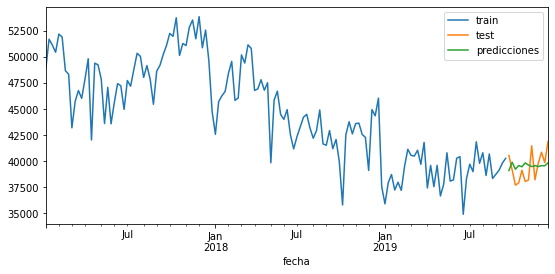

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

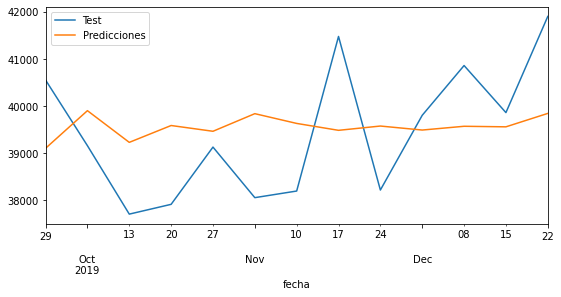

In [ ]:
# Ampliamos el gráfico de las predicciones comparada con los datos reales
fig, ax = plt.subplots(figsize=(9, 4))
test.plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predicciones')
ax.legend();

In [ ]:
# Error Random Forest Regressor
# ==============================================================================
rmse_rf1 = np.sqrt(mean_squared_error(y_true = test[:], y_pred = predicciones))
mape_rf1 = mean_absolute_percentage_error(y_true = test[:], y_pred = predicciones)*100
print(f"Error de test (rmse): {rmse_rf1}")
print(f"Error de test (mape): {mape_rf1}")

Error de test (rmse): 1387.9031053600156
Error de test (mape): 3.169769884167834


In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=42),
                    lags      = 16 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [10, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 13,
                        method      = 'cv',
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

2021-10-02 00:21:03,282 root       INFO  Number of models compared: 12
loop lags_grid: 100%|██████████| 2/2 [00:47<00:00, 23.97s/it]
2021-10-02 00:21:51,246 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
params: {'max_depth': 3, 'n_estimators': 100}



In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

lags  ... n_estimators
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  ...          100
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  ...          500
0                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  ...          100
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  ...          500
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  ...          100
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  ...          500
1                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  ...          500
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  ...          100
2                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  ...          100
4                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  ...          100
3                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  ...          500
5                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  ...          500

[12 rows x 5 columns]

In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=42)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 16
                )

forecaster_rf.fit(y=train)

In [ ]:
# Predicciones
# ==============================================================================
steps = 13
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=test.index)

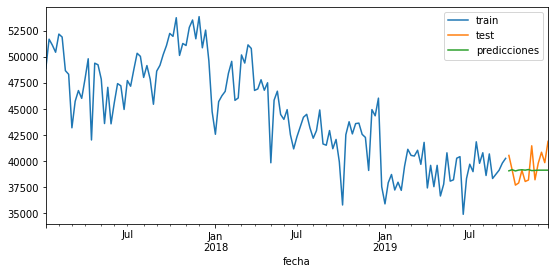

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

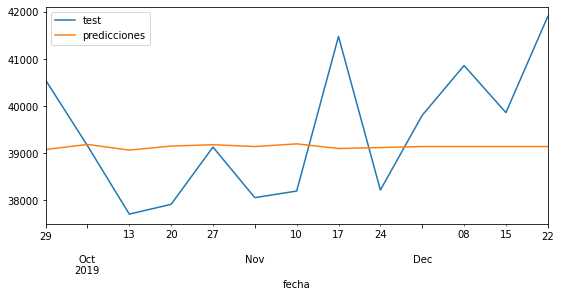

In [ ]:
# Zoom a la predicción
fig, ax = plt.subplots(figsize=(9, 4))
test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Errores Random Forest Regressor
# ==============================================================================
rmse_rf2 = np.sqrt(mean_squared_error(y_true = test[:], y_pred = predicciones))
mape_rf2 = mean_absolute_percentage_error(y_true = test[:], y_pred = predicciones)*100
print(f"RMSE Random Forest Default: {rmse_rf1}")
print(f"RMSE Random Forest CV: {rmse_rf2}")
print(f"MAPE Random Forest Default: {mape_rf1}")
print(f"MAPE Random Forest CV: {mape_rf2}")

RMSE Random Forest Default: 1387.9031053600156
RMSE Random Forest CV: 1407.696748927865
MAPE Random Forest Default: 3.169769884167834
MAPE Random Forest CV: 2.9652844774255636


Podemos observar que se obtuvieron mejores resultados permitiendo al modelo elegir sus propios hiperparametros, que con la validación cruzada realizada. 

# Resultados 2019

In [ ]:
bold('SEMANAL')
print('RMSE | BENCHMARK Media móvil: ', round(rmse_benchmark,2))
print('RMSE | BENCHMARK Regresión Lineal: ', round(rmse_lineal,2))
print('RMSE | ARIMA Out of sample: ', round(rmse_arima_oos,2))
print('RMSE | SARIMA Out of sample: ', round(rmse_sarima_oos,2))
print('RMSE | RANDOM FOREST: ', round(rmse_rf1,2))
print('RMSE | XGBOOST: ', round(rmse_test_xgb_best,2))
print('')
print('MAPE | BENCHMARK Media móvil: ', round(mape_benchmark,2))
print('MAPE | BENCHMARK Regresión Lineal: ', round(mape_lineal,2))
print('MAPE | ARIMA Out of sample: ', round(mape_arima_oos,2))
print('MAPE | SARIMA Out of sample: ', round(mape_sarima_oos,2))
print('MAPE | RANDOM FOREST: ', round(mape_rf1,2))
print('MAPE | XGBOOST: ', round(mape_test_xgb_best,2))
bold('\nDIARIO')
print('RMSE | ARIMA Out of sample: ', round(rmse_arima_oos_d,2))
print('RMSE | SARIMA Out of sample: ', round(rmse_sarima_oos_d,2))
print('')
print('MAPE | ARIMA Out of sample: ', round(mape_arima_oos_d,2))
print('MAPE | SARIMA Out of sample: ', round(mape_sarima_oos_d,2))

SEMANAL
RMSE | BENCHMARK Media móvil:  1770.12
RMSE | BENCHMARK Regresión Lineal:  1527.54
RMSE | ARIMA Out of sample:  2726.9
RMSE | SARIMA Out of sample:  2780.55
RMSE | RANDOM FOREST:  1387.9
RMSE | XGBOOST:  1476.28

MAPE | BENCHMARK Media móvil:  3.51
MAPE | BENCHMARK Regresión Lineal:  3.47
MAPE | ARIMA Out of sample:  5.04
MAPE | SARIMA Out of sample:  6.25
MAPE | RANDOM FOREST:  3.17
MAPE | XGBOOST:  3.04

DIARIO
RMSE | ARIMA Out of sample:  6720.57
RMSE | SARIMA Out of sample:  7325.54

MAPE | ARIMA Out of sample:  12.26
MAPE | SARIMA Out of sample:  16.16


Trabajando con los datos semanales los mejores resultados los obtenemos con el modelo de **Random Forest Regressor**. El modelo de XGBoost obtiene un resultado levemente mejor con la medición MAPE, pero vemos que el modelo muestra señales de overfiting. 

Vamos a utilizar el modelo de **Random Forest Regressor** ejecutado sobre el dataset año 2020 con granularidad semanal para ver cómo se comporta el modelo. 

# Dataset 2020

---
**Introducción**: En esta sección aplicare los modelos para predecir el tránsito vehicular del peaje ILLIA con pago EFECTIVO. 

El año 2020 es particular debido a las restricciones de circulación, provocadas por la cuarentena decretada por el Covid-19. 

Comenzaré haciendo un pequeño análisis de los valores diarios y semanales de 2020. 


---



In [ ]:
print(data_2020.head())
print(data_2020.tail())

   periodo                fecha  ...    sentido cantidad_pasos
0   2020.0  2020-01-01 00:00:00  ...     Centro           24.0
1   2020.0  2020-01-01 00:00:00  ...  Provincia           80.0
2   2020.0  2020-01-01 00:00:00  ...  Provincia            1.0
3   2020.0  2020-01-01 00:00:00  ...     Centro            1.0
4   2020.0  2020-01-01 00:00:00  ...  Provincia            1.0

[5 rows x 13 columns]
         periodo       fecha  ...    sentido cantidad_pasos
2533738   2020.0  2020-12-31  ...     Centro            1.0
2533739   2020.0  2020-12-31  ...  Provincia            1.0
2533740   2020.0  2020-12-31  ...     Centro            1.0
2533741   2020.0  2020-12-31  ...     Centro            2.0
2533742   2020.0  2020-12-31  ...  Provincia            1.0

[5 rows x 13 columns]


In [ ]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
dataset = data_2020.copy()
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','mes', 'dia', 'dia_fecha', 'tipo_vehiculo', 'observacion', 'sentido', 'hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.shape

(52374, 3)

In [ ]:
print(dataset.head())
print(dataset.tail())

                   fecha  hora_fin  cantidad_pasos
52   2020-01-01 00:00:00       1.0           326.0
53   2020-01-01 00:00:00       1.0           319.0
134  2020-01-01 00:00:00       2.0           199.0
135  2020-01-01 00:00:00       2.0           180.0
202  2020-01-01 00:00:00       3.0           114.0
              fecha  hora_fin  cantidad_pasos
2532216  2020-12-24      12.0             1.0
2532227  2020-12-24      13.0             1.0
2532271  2020-12-24      18.0             1.0
2532928  2020-12-28      13.0             1.0
2533497  2020-12-30      14.0             4.0


In [ ]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)

print(dataset.head())
print(dataset.tail())

   cantidad_pasos      fecha
0             7.0 2020-01-01
1           423.0 2020-01-01
2           467.0 2020-01-01
3             6.0 2020-01-01
4             1.0 2020-01-01
       cantidad_pasos               fecha
52369           222.0 2020-12-31 20:00:00
52370           106.0 2020-12-31 21:00:00
52371             5.0 2020-12-31 21:00:00
52372             1.0 2020-12-31 21:00:00
52373           103.0 2020-12-31 21:00:00


## Dataset diario 2020

In [ ]:
#Resampleamos nuestros datos para agrupar POR DÍA, y asi tal vez lograr una visualización mas amigable
diario_2020 = dataset.resample('D', on = 'fecha').sum()
print(diario_2020.shape)
print(diario_2020.head(3))
print(diario_2020.tail(3))

(366, 1)
            cantidad_pasos
fecha                     
2020-01-01         21395.0
2020-01-02         33722.0
2020-01-03         37067.0
            cantidad_pasos
fecha                     
2020-12-29         12036.0
2020-12-30         12527.0
2020-12-31          6553.0


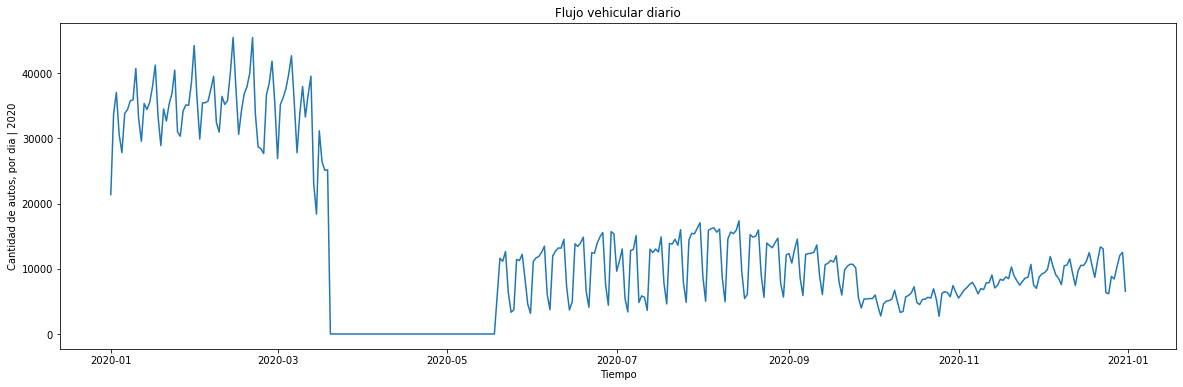

In [ ]:
# Gráfico diario 2020
plt.figure(figsize = (20,6))
plt.plot(diario_2020.index, diario_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia | 2020')
plt.title('Flujo vehicular diario')
plt.show()

En el primer gráfico de los valores diarios para 2020, podemos observar que a fines de marzo los valores bajan drásticamente. Luego a fines de mayo ser normalizan pero en una escala menor. Por último a fines de septiembre se observa un cambio en el gráfico. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Boxplot cantidad de pasos diarios')

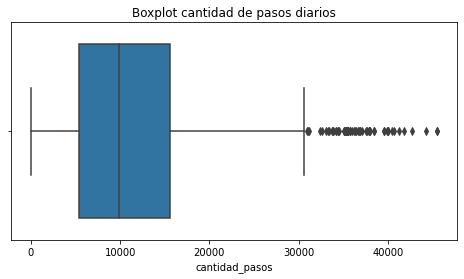

In [ ]:
# OUTLIERS
plt.figure(figsize=(8,4))
sns.boxplot(diario_2020.cantidad_pasos)
plt.title('Boxplot cantidad de pasos diarios')

En el boxplot vemos que los mayores valores son tomados como atípicos, siendo que en los años anteriores esos valores eran los normales. La media esta baja, y los valores que parecen atípicos en el gráfico diario, están dentro de los "bigotes" en el boxplot. 

En base a éstos gráficos, realizamos una pequeña investigación de contexto y vemos que el días **20 de marzo de 2020 se deja de cobrar peaje, y se reanuda el cobro a partir del 19 de mayo**. Además, como forma de prevención del Covid-19 se incentiva a utilizar formas de pago eletrónicas, lo que afecta nuestro dataset Illi-Efectivo, como se observa en el gráfico diario. 

[Publicación de Télam](https://www.telam.com.ar/notas/202005/465594-rige-nuevamente-el-cobro-de-peajes-en-las-autopistas-de-acceso-a-buenos-aires.html)

A continuación graficamos los valores de esas fechas.  

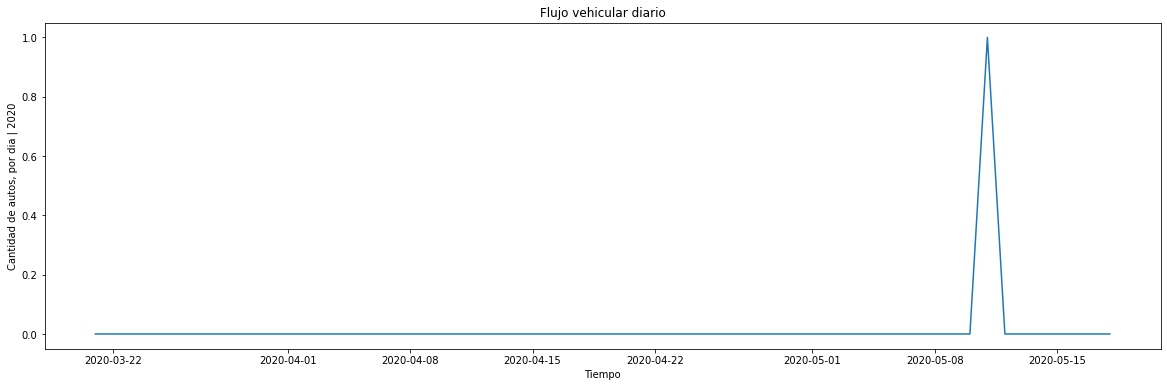

In [ ]:
# Gráfico diario 2020
plt.figure(figsize = (20,6))
plt.plot(diario_2020[(diario_2020.index > '2020-03-20') & (diario_2020.index < '2020-05-19') ])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia | 2020')
plt.title('Flujo vehicular diario')
plt.show()


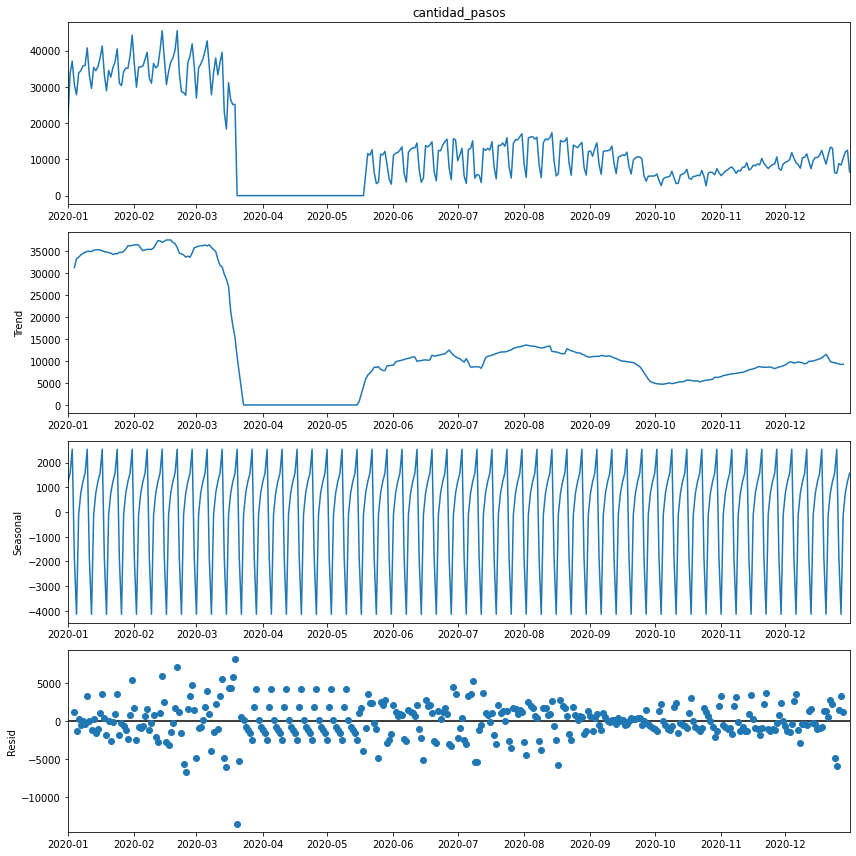

In [ ]:
# DIARIA: Estacionalidad, tendencia, ruido
result = seasonal_decompose(diario_2020.cantidad_pasos, model='additive')
plt.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

## Dataset semanal 2020

Hacemos el mismo análisis que hicimos para el dataset diario. 

In [ ]:
# Resampleamos nuestros datos para agrupar POR SEMANA, y asi tal vez lograr una visualización mas amigable
semanal_2020 = diario_2020.resample(rule='w', closed='left').mean()
# semanal = dataset.resample(rule='W', on = 'fecha', closed='left', label ='right').sum()
print(semanal_2020.shape)
print(semanal_2020.head())
print(semanal_2020.tail())

(53, 1)
            cantidad_pasos
fecha                     
2020-01-05    30702.750000
2020-01-12    34515.428571
2020-01-19    35354.142857
2020-01-26    34251.285714
2020-02-02    36254.142857
            cantidad_pasos
fecha                     
2020-12-06     9502.000000
2020-12-13     9580.857143
2020-12-20    10332.571429
2020-12-27     9668.571429
2021-01-03     9972.200000


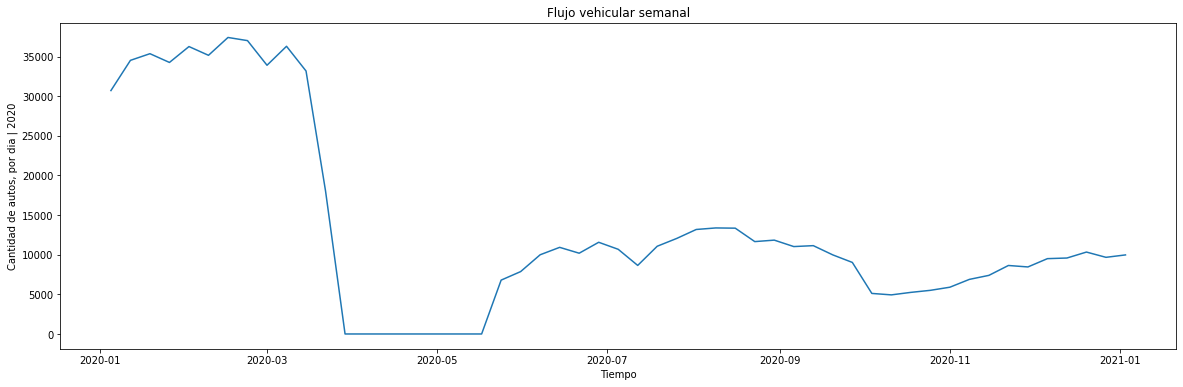

In [ ]:
# Gráfico semanal 2020
plt.figure(figsize = (20,6))
plt.plot(semanal_2020.index, semanal_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia | 2020')
plt.title('Flujo vehicular semanal')
plt.show()

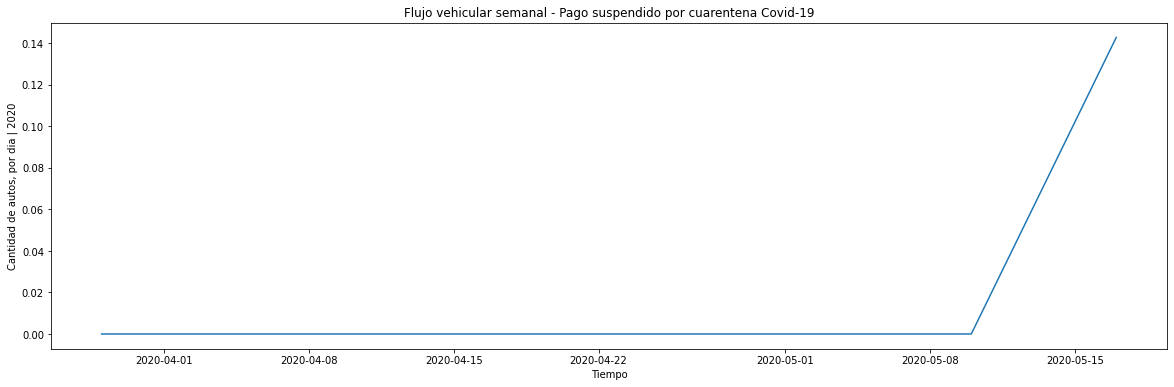

In [ ]:
# Gráfico semanal 2020
plt.figure(figsize = (20,6))
plt.plot(semanal_2020[(semanal_2020.index > '2020-03-22') & (semanal_2020.index < '2020-05-24') ])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia | 2020')
plt.title('Flujo vehicular semanal - Pago suspendido por cuarentena Covid-19')
plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Boxplot cantidad de pasos semanal')

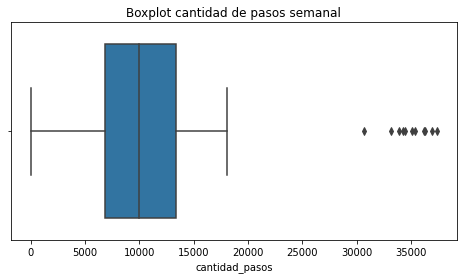

In [ ]:
# OUTLIERS
plt.figure(figsize=(8,4))
sns.boxplot(semanal_2020.cantidad_pasos)
plt.title('Boxplot cantidad de pasos semanal')

Observamos que en el dataset semanal ocurre lo mismo que en el diario. 

**Conclusión del análisis de datos 2020**: Al ser un año particular por las cuestiones ya nombradas, seguramente ningún modelo pueda predecir estas situaciones. 

A los fines del trabajo solicitado (Utiliza el modelo creado para predecir el tráfico en el año 2020.) voy a aplicar el modelo seleccionado en la primera parte para predecir el 2020 completo, y tambien voy a tomar la primera parte del dataset 2020 hasta el 19 de marzo, donde entiendo que los datos fueron normales (pre covid-19). 

Voy a tomar estos datos como test para comparar con las predicciones del modelo, y calcular sus respectivos errores. 

### Random Forest Semanal para 2020

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster_rf = ForecasterAutoreg(
                    regressor=RandomForestRegressor(random_state=42),
                    lags=16
                )

forecaster_rf.fit(y=semanal.cantidad_pasos)

forecaster_rf

=======================ForecasterAutoreg=======================
Regressor: RandomForestRegressor(random_state=42)
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Exogenous variable: False, None
Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

In [ ]:
# Predicciones
# ==============================================================================
steps =53
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice temporal a las predicciones
predicciones = pd.Series(data=predicciones, index=semanal_2020.index)
predicciones.head()

fecha
2020-01-05    39746.588571
2020-01-12    38571.553571
2020-01-19    39080.464286
2020-01-26    38964.747857
2020-02-02    38830.110714
Freq: W-SUN, dtype: float64

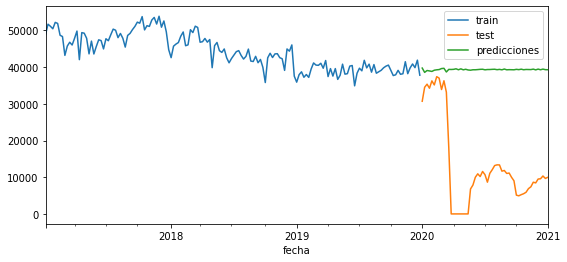

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
semanal.cantidad_pasos.plot(ax=ax, label='train')
semanal_2020.cantidad_pasos.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

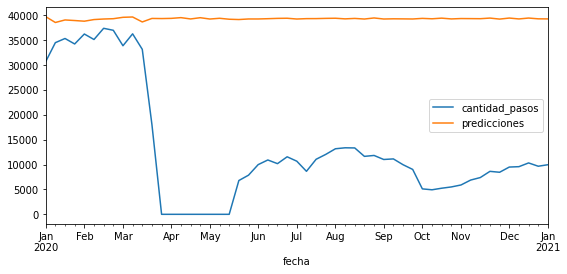

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#semanal.cantidad_pasos.plot(ax=ax, label='train')
semanal_2020.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error
# ==============================================================================
rmse_rf_2020 = np.sqrt(mean_squared_error(y_true = semanal_2020[:], y_pred = predicciones))
mape_rf_2020 = mean_absolute_percentage_error(y_true = semanal_2020[:], y_pred = predicciones)*100
print(f"Error de test (rmse): {rmse_rf_2020}")
print(f"Error de test (mape): {mape_rf_2020}")

Error de test (rmse): 28416.595411283488
Error de test (mape): 2.3436252724293542e+21


### Random Forest Semanal para el 1er trimestre del 2020

En base a los comentarios realizados acerta de la anormalidad mundial producida por el virus Covid-19, realizare una prueba del modelo seleccionado, para predecir el primer trimestre de 2020, hasta donde fue decretada la cuarentena y prohibición de la circulación. 

In [ ]:
semanal_2020_Q1 = semanal_2020[(semanal_2020.index < '2020-03-22')]

In [ ]:
print(semanal_2020_Q1.shape)
print(semanal_2020_Q1.head(3))
print(semanal_2020_Q1.tail(3))

(11, 1)
            cantidad_pasos
fecha                     
2020-01-05    30702.750000
2020-01-12    34515.428571
2020-01-19    35354.142857
            cantidad_pasos
fecha                     
2020-03-01    33896.428571
2020-03-08    36288.714286
2020-03-15    33171.285714


In [ ]:
predicciones_2020_Q1 = predicciones[:11]

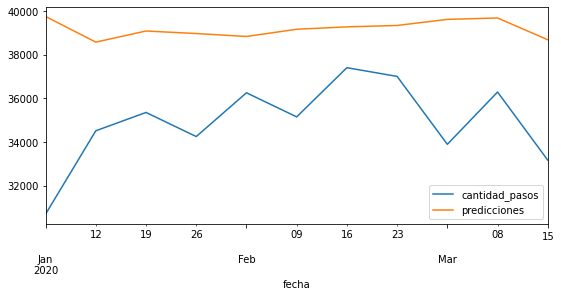

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
#semanal.cantidad_pasos.plot(ax=ax, label='train')
semanal_2020_Q1.plot(ax=ax, label='test')
predicciones_2020_Q1.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
rmse_rf_2020_Q1 = np.sqrt(mean_squared_error(y_true = semanal_2020_Q1[:], y_pred = predicciones_2020_Q1))
mape_rf_2020_Q1 = mean_absolute_percentage_error(y_true = semanal_2020_Q1[:], y_pred = predicciones_2020_Q1)*100
print(f"Error de test (rmse): {rmse_rf_2020_Q1}")
print(f"Error de test (mape): {mape_rf_2020_Q1}")

Error de test (rmse): 4675.522189230511
Error de test (mape): 12.55598269983291


# Resultados globales

In [ ]:
bold('SEMANAL')
bold('Último trimestre de 2019')
print('RMSE | BENCHMARK Media móvil: ', round(rmse_benchmark,2))
print('RMSE | BENCHMARK Regresión Lineal: ', round(rmse_lineal,2))
print('RMSE | RANDOM FOREST: ', round(rmse_rf1,2))
print('')
print('MAPE | BENCHMARK Media móvil: ', round(mape_benchmark,2))
print('MAPE | BENCHMARK Regresión Lineal: ', round(mape_lineal,2))
print('MAPE | RANDOM FOREST: ', round(mape_rf1,2))
print('')
bold('Año 2020 completo')
print('RMSE | RANDOM FOREST: ', round(rmse_rf_2020,2))
print('MAPE | RANDOM FOREST: ', round(mape_rf_2020,2))
print('')
bold('Primer trimestre de 2020')
print('RMSE | RANDOM FOREST: ', round(rmse_rf_2020_Q1,2))
print('MAPE | RANDOM FOREST: ', round(mape_rf_2020_Q1,2))

SEMANAL
Último trimestre de 2019
RMSE | BENCHMARK Media móvil:  1770.12
RMSE | BENCHMARK Regresión Lineal:  1527.54
RMSE | RANDOM FOREST:  1387.9

MAPE | BENCHMARK Media móvil:  3.51
MAPE | BENCHMARK Regresión Lineal:  3.47
MAPE | RANDOM FOREST:  3.17

Año 2020 completo
RMSE | RANDOM FOREST:  28416.6
MAPE | RANDOM FOREST:  2.3436252724293542e+21

Primer trimestre de 2020
RMSE | RANDOM FOREST:  4675.52
MAPE | RANDOM FOREST:  12.56


**Conclusiones finales**

Luego del análisis y tratado de los datos de circulación vehicular para el peaje Illia con pago en Efectivo de los años de 2017 a 2020, pudimos aplicar modelo de predicción que nos permiten obtener valores con errores suficientemente bajos como para tenerlos en cuenta. 

El modelo que mejores valores obtuvo fue el **Random Forest Regressor**. 

Para el caso de la predicción para el año 2020, podemos observar que el error en la predicción es bastante alto, debido a las particularidades de circulación de ese año, explicadas en el desarrollo. Por lo que consideramos que ese año en particular debe ser tratado de una manera especial, vinculando las variables exógenas de prohibición de circulación, generalmente vinculada a la cantidad de casos positivos de Covid 19. 

# **PARTE C - Investigación**

En base a este primer análisis de los datos, surgen ciertas ideas que pretendo aplicar en el próximo trabajo. 
1. **Agregar datos**: En primer lugar voy a agregar los datos de 2016 para tener más datos para alimentar los modelos, y probar si se obtienen mejores resultados para predecir el último trimestre de 2019 y todo el 2020.
 


2. **Formas de pago**: Como se observa en el gráfico a continuación, y como vimos a lo largo del trabajo, vemos que existe una tendencia decreciente del tipo de pago Efectivo, mientras que por otro lado, el tipo de pago Telepase parece reemplazar al Efectivo, al tener una tendencia creciente. También se sabe que luego de la cuarentena por Covid 19 desde Mayo 2020 se hizo una fuerte campaña para dejar la forma de pago Efectivo, y pasarse a formas de pago sin contacto, como es el Telepase. La propuesta es hacer el análisis del peaje Illia con forma de pago Telepase y también hacer el análisis del peaje Illia con TODAS las formas de pago, para analizar las tendencias de circulación de esa vía, más allá de forma de pago.

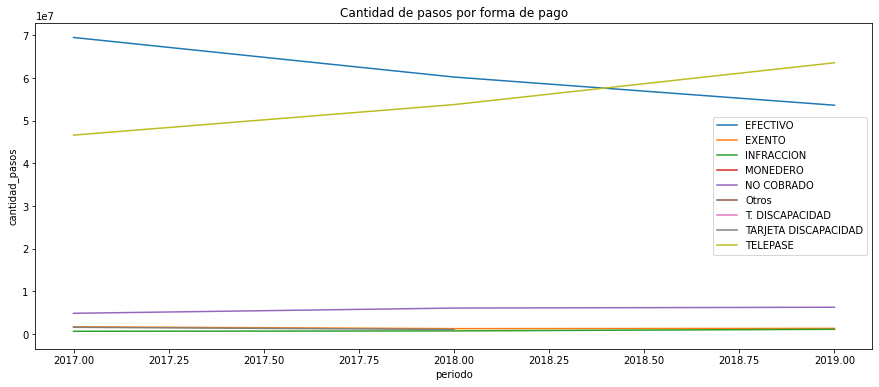

In [ ]:
# Gráfico de las Formas de Pago
plt.figure(figsize=(15, 6))
sns.lineplot(x=forma_pago.periodo, y= forma_pago.cantidad_pasos, hue=forma_pago.forma_pago)
plt.title('Cantidad de pasos por forma de pago')
plt.legend(loc='best')
plt.show()

3. **Modelos avanzados**: Utilizar modelos de predicción más avanzados y ver qué resultados obtenemos. Los modelos propuestos los **Prophet** de Facebook, que tiene algunas características como por ejemplo la posibilidad de tener en cuenta feriados y fechas especiales en la predicción. Otra propuesta que se ajusta a nuestros datos es usar **Redes Neuronales**, más específicamente el modelo Long Short Term Memory (**LSTM**).

+ [Artículo sobre Prophet](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/)

+ [Artículo sobre LSTM](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
